In [1]:
#!/usr/bin/python
# -*- coding: latin-1 -*-
"""This notebook creates the statistics of TAG in Spain in YEAR"""

import inspect, os, sys

try :
    import pywikibot as pb
    from pywikibot import pagegenerators, textlib
    from pywikibot.specialbots import UploadRobot

except :
    current_folder = os.path.realpath(os.path.abspath(os.path.split(inspect.getfile(inspect.currentframe()))[0]))
    folder_parts = current_folder.split(os.sep)
    pywikibot_folder = os.sep.join(folder_parts[:-1])

    if current_folder not in sys.path:
        sys.path.insert(0, current_folder)
    if pywikibot_folder not in sys.path:
        sys.path.insert(0, pywikibot_folder)

    import pywikibot as pb
    from pywikibot import pagegenerators, textlib
    from pywikibot.specialbots import UploadRobot

import mwparserfromhell as mwh

In [2]:
from modules.wmtools import upload_to_commons, get_registration_time, heat_color, get_project_name, wrap_label

D:\Datos\Miguel-Angel\Code\Python\core\wmtools3


In [3]:
import pandas as pd
import numpy as np
from mako.template import Template
from io import StringIO, BytesIO
from datetime import datetime, timedelta
from urllib.parse import urlencode
import requests
import json
from itertools import groupby
from operator import itemgetter
from functools import reduce
import math
import random

In [4]:
from geojson import Feature, Point, FeatureCollection
import geojson

In [5]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator
import seaborn as sns

sns.set_style("darkgrid")
%matplotlib inline

In [6]:
YEAR                = 2016
TAG                 = 'WLF'
TAG_EXT             = 'Wiki Loves Folk'

BASE_WLF_NAME       = 'Commons:{1}/{0}'.format(YEAR, TAG_EXT)
BASE_WLF2016_NAME   = 'Commons:{1}/{0}'.format(2016, TAG_EXT)
LOG_PAGE            = BASE_WLF_NAME + '/Log'
STATISTICS_PAGE     = BASE_WLF_NAME + '/Stats'
FESTIVAL_DB_PAGE    = BASE_WLF2016_NAME + '/Festival DB'
GALLERY_QI          = BASE_WLF_NAME + '/QI'

VALID_NAMESPACES    = ['0', '4', '100', '104']
DAYS_BEFORE_REGISTRATION = 15

WLF_FINALIST_CATEGORY = "Category:Images from {1} {0} in Spain (finalists)".format(YEAR, TAG_EXT)

commons_site = pb.Site('commons', 'commons')

In [7]:
MW_API_BASE_URL     = 'https://commons.wikimedia.org/w/api.php'
MW_API_QUERY_STRING = {"action": "query",
                       "format": "json",
                       "gulimit": "500",
                       "prop": "globalusage",
                       "guprop": "url|namespace",
                       "titles": None
                      }

In [8]:
figsize=[15., 10.]
figsize_half=[8., 10.]
figsize_high=[15., 30.]
figsize_low=[15., 6.]

In [9]:
shake_step=0.01

In [10]:
cwd = os.getcwd()

images_directory = os.path.join(cwd, 'images')
if not os.path.exists(images_directory):
    os.makedirs(images_directory)
    
templates_directory = os.path.join(cwd, 'templates')

In [11]:
now = (datetime.now().strftime("%Y-%m-%d"))

In [12]:
def get_campaign (row):
    """Function that classifies images according to uploade date.
    THIS IS A YEAR-DEPENDENT FUNCTION"""
    start_datetime_fallas = datetime(YEAR, 4, 1)
    end_datetime_fallas   = datetime(YEAR, 5, 1) + timedelta(hours=2)
    start_datetime_summer = datetime(YEAR, 8, 25)
    end_datetime_summer   = datetime(YEAR, 9, 6) + timedelta(hours=2)
    start_datetime_autumm = datetime(YEAR, 11, 25)
    end_datetime_autumm   = datetime(YEAR, 12, 16) + timedelta(hours=2)
    
    if (row['timestamp'] > start_datetime_fallas) and (row['timestamp'] < end_datetime_fallas):
        return "spring"
    elif (row['timestamp'] > start_datetime_summer) and (row['timestamp'] < end_datetime_summer):
        return "summer"
    elif (row['timestamp'] > start_datetime_autumm) and (row['timestamp'] < end_datetime_autumm):
        return "autumn"
    else :
        return ""

In [13]:
def expand_itemid (_list):
    new_list = [{"itemid": i, "category": festivals_df[festivals_df['wikidata_id'] == i]['category'].values[0]} for i in _list]
    if len(new_list) > 0:
        new_list = sorted(new_list, key=lambda k: k['category']) 
    return new_list

def decode_list (_list) :
    try:
        new_list = _list[:]
    except :
        new_list = []
    return new_list

In [14]:
def shaker (row) :
    coordinates = (row['latitude'], row['longitude'])
    if row['dup'] == True:
        random.seed(len(row['category']))
        term_selector = random.randint(0,1)
        sign_selector = -1
        if random.random() < 0.5 :
            sign_selector = 1
        shake = [0.0] * 2
        shake[term_selector] = sign_selector*shake_step
        shake = set(shake)
        coordinates = tuple(x + y for x, y in zip(shake, coordinates))

    return coordinates

In [15]:
def to_geojson (row) :
    reduced_images_df = images_df[images_df['wikidata_id'] == row['wikidata_id']]
    if len(reduced_images_df[reduced_images_df['qi'] == 'qi']) > 0 :
        image = reduced_images_df[reduced_images_df['qi'] == 'qi'].sample(1, random_state=0)['image_title'].values[0]
    elif len(reduced_images_df[reduced_images_df['finalist'] == 'finalist']) > 0 :
        image = reduced_images_df[reduced_images_df['finalist'] == 'finalist'].sample(1, random_state=0)['image_title'].values[0]
    else :
        image = reduced_images_df.sample(1, random_state=0)['image_title'].values[0]

    feature = Feature(geometry=Point((row['longitude'], row['latitude'])), 
                      properties={"description": "[[File:{0}|150px]]".format(image),
                                  "title": "[[:Category:Images of festival with code {0} from {2} {1} in Spain|{3}]]".format(row['wikidata_id'], YEAR, TAG_EXT, row['category']),
                                  "marker-size": "small",
                                  "marker-symbol": "circle",
                                  "marker-color": autcom_colors[row['aut_com']]}
                     )
    return feature

In [16]:
# Image description
plot_description = """== {{{{int:filedesc}}}} ==
{{{{Information
|description={{{{en|{2}}}}}
|source={{{{own}}}}
|author=[[User:Discasto|Discasto]]
|date={3}
}}}}

{{{{Created with Matplotlib}}}}

== {{{{int:license-header}}}} ==
{{{{self|cc-by-sa-4.0}}}}

[[Category:Photos by User:Discasto]]
[[Category:{0} {1} in Spain]]"""

In [17]:
festival_annexes = [
    ['Anexo:Fiestas de interés turístico de Andalucía', 'Andalusia'],
    ['Anexo:Fiestas de interés turístico de Aragón', 'Aragon'],
    ['Anexo:Fiestas de interés turístico de Asturias', 'Asturias'],
    ['Anexo:Fiestas de interés turístico de Cantabria', 'Cantabria'],
    ['Anexo:Fiestas de interés turístico de Castilla-La Mancha', 'Castile-La Mancha'],
    ['Anexo:Fiestas de interés turístico de Castilla y León', 'Castile and León'],
    ['Anexo:Fiestas de interés turístico de Cataluña', 'Catalonia'],
    ['Anexo:Fiestas de interés turístico de la Comunidad de Madrid', 'Community of Madrid'],
    ['Anexo:Fiestas de interés turístico de la Comunidad Valenciana', 'Valencian Community'],
    ['Anexo:Fiestas de interés turístico de Extremadura', 'Extremadura'],
    ['Anexo:Fiestas de interés turístico de las Islas Baleares', 'Balearic Islands'],
    ['Anexo:Fiestas de interés turístico de las Islas Canarias', 'Canary Islands'],
    ['Anexo:Fiestas de interés turístico de Galicia', 'Galicia'],
    ['Anexo:Fiestas de interés turístico de La Rioja', 'La Rioja'],
    ['Anexo:Fiestas de interés turístico de Navarra', 'Navarre'],
    ['Anexo:Fiestas de interés turístico de la Región de Murcia', 'Region of Murcia'],
    ['Anexo:Fiestas y tradiciones del País Vasco', 'Basque Country']
]
annexes = pd.DataFrame(data=festival_annexes, columns=['annex', 'aut_com']).set_index(['aut_com'])['annex']

annexes

aut_com
Andalusia                Anexo:Fiestas de interés turístico de Andalucía
Aragon                      Anexo:Fiestas de interés turístico de Aragón
Asturias                  Anexo:Fiestas de interés turístico de Asturias
Cantabria                Anexo:Fiestas de interés turístico de Cantabria
Castile-La Mancha      Anexo:Fiestas de interés turístico de Castilla...
Castile and León       Anexo:Fiestas de interés turístico de Castilla...
Catalonia                 Anexo:Fiestas de interés turístico de Cataluña
Community of Madrid    Anexo:Fiestas de interés turístico de la Comun...
Valencian Community    Anexo:Fiestas de interés turístico de la Comun...
Extremadura            Anexo:Fiestas de interés turístico de Extremadura
Balearic Islands       Anexo:Fiestas de interés turístico de las Isla...
Canary Islands         Anexo:Fiestas de interés turístico de las Isla...
Galicia                    Anexo:Fiestas de interés turístico de Galicia
La Rioja                  Anexo:Fiestas de 

In [18]:
autcom_palette = [i[1:] for i in sns.color_palette('hls', 17).as_hex()]
autcoms = [i[1] for i in festival_annexes]
autcom_colors = {autcom: autcom_palette[i] for i, autcom in enumerate(autcoms)}
autcom_colors

{'Andalusia': 'db5f57',
 'Aragon': 'db8d57',
 'Asturias': 'dbbc57',
 'Balearic Islands': '578ddb',
 'Basque Country': 'db577e',
 'Canary Islands': '575edb',
 'Cantabria': 'ccdb57',
 'Castile and León': '6edb57',
 'Castile-La Mancha': '9ddb57',
 'Catalonia': '57db6e',
 'Community of Madrid': '57db9d',
 'Extremadura': '57bcdb',
 'Galicia': '7e57db',
 'La Rioja': 'ad57db',
 'Navarre': 'db57db',
 'Region of Murcia': 'db57ac',
 'Valencian Community': '57dbcc'}

In [19]:
pb.output('Retrieving --> {0} in Spain Festivals list from cache'.format(TAG))
festival_list_page = pb.Page(commons_site, FESTIVAL_DB_PAGE)
festival_list_text = StringIO(festival_list_page.text[festival_list_page.text.find('\n') + 1:festival_list_page.text.rfind('\n')])
festivals_df = pd.read_csv(festival_list_text, 
                           sep=";", 
                           index_col=False, 
                           names=['name', 'aut_com', 
                                  'wikidata_id', 'wikidata_timestamp', 
                                  'category', 'cat_timestamp', 'image',
                                  'latitude', 'longitude']
                          )
pb.output('Retrieved --> {0} in Spain Festivals list from cache'.format(TAG))

Retrieving --> WLF in Spain Festivals list from cache
Retrieved --> WLF in Spain Festivals list from cache


In [20]:
festivals_df.head()

,name,aut_com,wikidata_id,wikidata_timestamp,category,cat_timestamp,image,latitude,longitude
0,Carnaval de Cádiz,Andalusia,Q2939698,1.358030e+12,Carnival of Cádiz,1.172166e+12,Carnavaldecadiz.jpg,36.516667,-6.283333
1,Semana Santa en Málaga,Andalusia,Q9075883,1.364769e+12,Holy Week in Málaga,1.262418e+12,"Cristo de La Humillacion y Perdón, Lateral izq...",36.716667,-4.416667
2,Semana Santa de Sevilla,Andalusia,Q1469338,1.356186e+12,Holy Week in Seville,1.270393e+12,Macarena Sevilla-detail.jpg,37.383333,-5.983333
3,Semana Santa en Granada,Andalusia,Q9075873,1.364769e+12,Holy Week in Granada,1.239229e+12,Venerable Hermandad del Santísimo Cristo de la...,37.178056,-3.600833
4,Feria de Abril,Andalusia,Q2918983,1.357986e+12,Feria de Abril,1.148114e+12,Séville-Féria de Abril-1028-1992 05 06.jpg,37.383333,-5.983333


In [21]:
festival_length = len(festivals_df.index)
festival_length

1238

In [22]:
valid_festivals = festivals_df['wikidata_id'].values
valid_festivals

array(['Q2939698', 'Q9075883', 'Q1469338', ..., 'Q23655957', 'Q23655971',
       'Q23655987'], dtype=object)

In [23]:
pb.output('Retrieving --> {1} {0} in Spain images list from cache'.format(YEAR, TAG))
list_page = pb.Page(commons_site, LOG_PAGE)
list_page_text = StringIO(list_page.text[list_page.text.find('\n') + 1:list_page.text.rfind('\n')])
images_df = pd.read_csv(list_page_text,
                            sep=";",
                            index_col=False,
                            names=['image_title', 'wikidata_id', 'uploader', 'time_to_upload', 'timestamp', 'qi', 'finalist']
                       ).fillna('')
pb.output('Retrieved --> {1} {0} in Spain images list from cache'.format(YEAR, TAG))

images_df['timestamp'] = pd.to_datetime(images_df['timestamp'], format="%Y-%m-%d %H:%M:%S")
images_df['campaign'] = images_df.apply (lambda row: get_campaign(row), axis=1)

images_df.set_index(["timestamp"], inplace=True)
del images_df.index.name

total_images_length = len(images_df)
total_images_length

Retrieving --> WLF 2016 in Spain images list from cache
Retrieved --> WLF 2016 in Spain images list from cache


1621

In [24]:
qi_list = images_df[images_df['qi'] == 'qi']['image_title']
qi_list

2016-12-07 20:57:21                         Cofradia de la Esperanza.jpg
2016-12-06 00:54:42                            Fallas2015 Falleras02.jpg
2016-04-02 17:58:27                  Fallas2016 Calles Iluminadas 02.jpg
2016-12-07 21:25:54                            Fallas2016 Peinado 02.jpg
2016-04-12 20:54:18                             Lagrimas - Mayordomo.jpg
2016-04-07 16:15:51    Procesión del Calvario en Córdoba, España (201...
2016-04-07 16:15:54    Procesión del Calvario en Córdoba, España (201...
2016-04-07 16:15:54    Procesión del Calvario en Córdoba, España (201...
2016-04-07 16:15:57    Procesión del Calvario en Córdoba, España (201...
2016-04-07 16:16:00    Procesión del Calvario en Córdoba, España (201...
Name: image_title, dtype: object

In [25]:
qi_length = len(qi_list)
qi_length

10

In [26]:
# THIS IS YEAR-DEPENDENT
campaign_count = images_df['campaign'].value_counts()
campaign_count = campaign_count.reindex(['spring', 'summer', 'autumn'])
campaign_count

spring    1146
summer      69
autumn     375
Name: campaign, dtype: int64

[[commons:File:WLF 2016 in Spain - Contributions by campaign.png]]


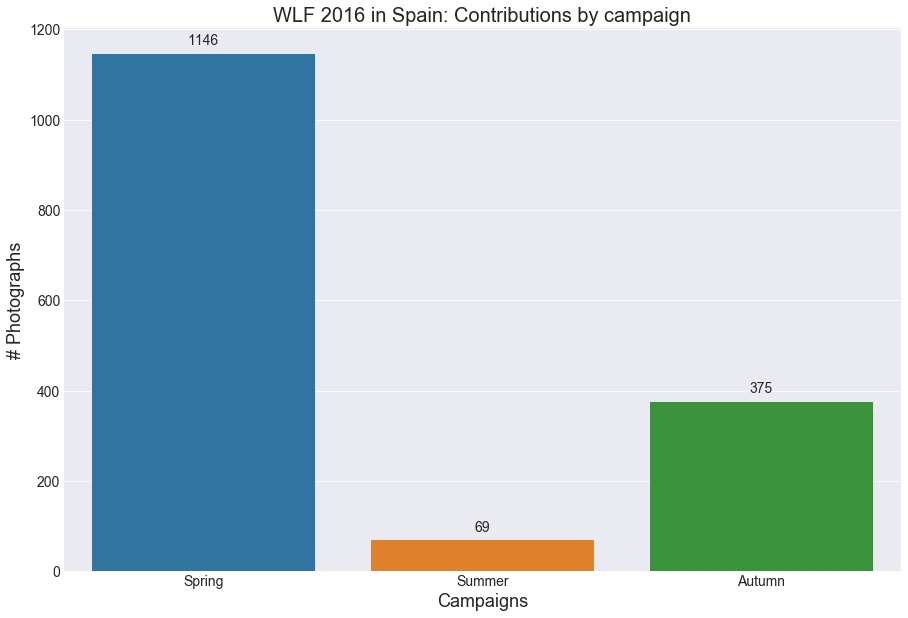

In [27]:
fig, ax = plt.subplots(figsize=figsize)

p = sns.barplot(ax=ax, x=campaign_count.index, y=campaign_count.values)
p.set_xlabel("Campaigns", fontsize=18)
p.set_ylabel("# Photographs", fontsize=18)

p.set_title(label='{1} {0} in Spain: Contributions by campaign'.format(YEAR, TAG), fontsize=20)
p.tick_params(labelsize=14)

# THIS IS YEAR-DEPENDENT
p.set_xticklabels(['Spring', 'Summer', 'Autumn'])

for patch in p.patches:
    height = patch.get_height()
    p.text(patch.get_x() + patch.get_width()/2.,
            height + 20,
            '{:1.0f}'.format(height),
            ha="center",
            fontsize=14)
    
upload_to_commons(p,
                  "{1} {0} in Spain - Contributions by campaign.png".format(YEAR, TAG),
                  '{1} {0} in Spain: Contributions by campaign'.format(YEAR, TAG_EXT),
                  plot_description,
                  YEAR,
                  TAG_EXT
                 )

In [28]:
uploaders = images_df.groupby(['uploader']).min()['time_to_upload']
uploaders

uploader
Adolfobrigido                 1191
Antonio Arenas                   0
Antonio Arenas Ramírez        1341
Antonio Sánchez                  0
B25es                         3567
Bertobarc90                    258
Castellónenred                3135
Coentor                       2938
Danielph147                   1039
Dbascones                      359
Dben eswiki                      0
Discasto                       763
El Pantera                    3283
ElBute                         316
Elnafe                           0
Emilio Luque                  1072
Gisela Dombek                    0
Jaime Calatayud                202
Jespa                         3571
Jorgemrtz                        0
Jovigama                      3109
Juan vi joan                     0
JulioC66                         0
Llapissera                    4001
Majopegolina                     1
Marsan                        1665
Maryna Dymovich                  0
Mikipons                      1678
Millars    

In [29]:
time_to_upload = uploaders.value_counts().sort_index(ascending=False)
time_to_upload

4001     1
3571     1
3567     1
3483     1
3285     1
3283     1
3135     1
3109     1
2938     1
2675     1
2537     1
2435     1
1721     1
1678     1
1665     1
1341     1
1310     1
1191     1
1072     1
1039     1
923      1
763      1
581      1
400      1
379      1
360      1
359      1
347      1
316      1
258      1
225      1
202      1
1        1
0       18
Name: time_to_upload, dtype: int64

In [30]:
age = pd.cut(uploaders, bins=[0, 15, 365, 730, 3650, 5000], include_lowest=True).value_counts()

[[commons:File:WLF 2016 in Spain - Contestant age.png]]


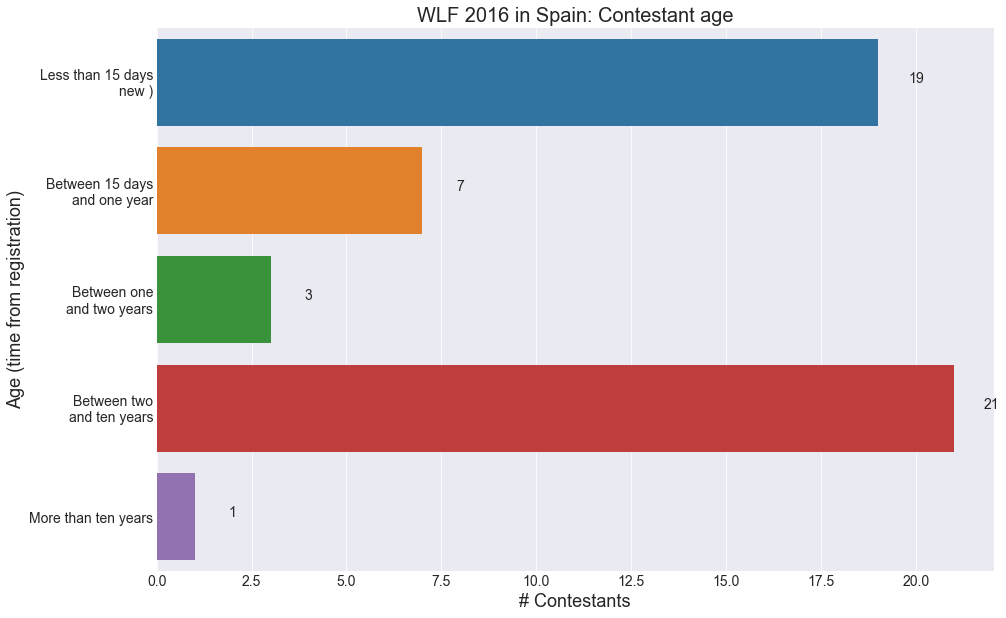

In [31]:
fig, ax = plt.subplots(figsize=figsize)

p = sns.barplot(ax=ax, y=age.index, x=age.values)
p.set_xlabel("# Contestants", fontsize=18)
p.set_ylabel("Age (time from registration)", fontsize=18)

p.set_title(label='{1} {0} in Spain: Contestant age'.format(YEAR, TAG), fontsize=20)
p.tick_params(labelsize=14)

p.set_yticklabels(['Less than 15 days\nnew )', 
                   'Between 15 days\nand one year', 
                   'Between one\nand two years', 
                   'Between two\nand ten years', 
                   'More than ten years'])

for patch in ax.patches:
    ax.text(patch.get_width() + 1,
            patch.get_y() + patch.get_height()/2.,
            '{:1.0f}'.format(patch.get_width()),
            ha="center",
            fontsize=14)

upload_to_commons(p,
                  "{1} {0} in Spain - Contestant age.png".format(YEAR, TAG),
                  '{1} {0} in Spain: Contestant age. Time from registration to first contribution to contest.'.format(YEAR, TAG_EXT),
                  plot_description,
                  YEAR,
                  TAG_EXT
                 )

In [32]:
authors_length = len(uploaders.index)
authors_length

51

In [33]:
images_per_uploader = images_df['uploader'].value_counts()
images_per_uploader = images_per_uploader.rename('images')
images_per_uploader

Pedro J Pacheco               508
El Pantera                    281
Rafesmar                      115
SiegluXXI                     106
Rodelar                        95
Millars                        72
Discasto                       67
Ricardo Yagüe                  58
SantiagoPucelano1              50
Tamara k                       25
Songbird8                      25
TaronjaSatsuma                 22
ElBute                         19
Castellónenred                 16
Mikipons                       13
Coentor                        12
Tordo12                        12
Orruza1983                     10
B25es                           9
Antonio Sánchez                 9
Jespa                           8
Marsan                          7
Nordentor                       7
Majopegolina                    7
Dben eswiki                     6
Maryna Dymovich                 5
Molsos                          5
Emilio Luque                    4
Antonio Arenas                  4
Adolfobrigido 

In [34]:
# New uploaders
days_before_registration = DAYS_BEFORE_REGISTRATION
new_uploaders = uploaders[uploaders<days_before_registration].index
new_uploaders

Index(['Antonio Arenas', 'Antonio Sánchez', 'Dben eswiki', 'Elnafe',
       'Gisela Dombek', 'Jorgemrtz', 'Juan vi joan', 'JulioC66',
       'Majopegolina', 'Maryna Dymovich', 'Mwernercasero', 'Niv66',
       'Rubenholguera', 'SEMANASANTACALLOSADESEGURA', 'SantiagoPucelano1',
       'Songbird8', 'Tomastt1983', 'Usoleris', 'Álvaro ArMo'],
      dtype='object', name='uploader')

In [35]:
new_uploaders_length = len(new_uploaders)
new_uploaders_length

19

In [36]:
new_uploaders = images_per_uploader[new_uploaders]
new_uploaders

uploader
Antonio Arenas                 4
Antonio Sánchez                9
Dben eswiki                    6
Elnafe                         2
Gisela Dombek                  3
Jorgemrtz                      1
Juan vi joan                   3
JulioC66                       1
Majopegolina                   7
Maryna Dymovich                5
Mwernercasero                  1
Niv66                          2
Rubenholguera                  3
SEMANASANTACALLOSADESEGURA     2
SantiagoPucelano1             50
Songbird8                     25
Tomastt1983                    1
Usoleris                       2
Álvaro ArMo                    1
Name: images, dtype: int64

In [37]:
images_per_uploader = images_df['uploader'].value_counts()
images_per_uploader = images_per_uploader.rename('images')
images_per_uploader = images_per_uploader.iloc[np.lexsort([images_per_uploader.index, -images_per_uploader.values])]
images_per_uploader

Pedro J Pacheco               508
El Pantera                    281
Rafesmar                      115
SiegluXXI                     106
Rodelar                        95
Millars                        72
Discasto                       67
Ricardo Yagüe                  58
SantiagoPucelano1              50
Songbird8                      25
Tamara k                       25
TaronjaSatsuma                 22
ElBute                         19
Castellónenred                 16
Mikipons                       13
Coentor                        12
Tordo12                        12
Orruza1983                     10
Antonio Sánchez                 9
B25es                           9
Jespa                           8
Majopegolina                    7
Marsan                          7
Nordentor                       7
Dben eswiki                     6
Maryna Dymovich                 5
Molsos                          5
Adolfobrigido                   4
Antonio Arenas                  4
Emilio Luque  

In [38]:
# THIS PARAMETER IS YEAR-DEPENDENT AND COMES FROM MANUAL INSPECTION
TOP_UPLOADERS = 13

In [39]:
images_per_uploader.size

51

In [40]:
remaining_images_per_uploader_count = images_per_uploader[TOP_UPLOADERS:].count()
remaining_images_per_uploader_count

38

In [41]:
remaining_images_per_uploader_sum = images_per_uploader[TOP_UPLOADERS:].sum()
remaining_images_per_uploader_sum

178

In [42]:
remaining_images_per_uploader = images_per_uploader[:TOP_UPLOADERS]
remaining_images_per_uploader = remaining_images_per_uploader.iloc[np.lexsort([remaining_images_per_uploader.index, -remaining_images_per_uploader.values])]
remaining_images_per_uploader = remaining_images_per_uploader.append(pd.Series(data={"Rest ({0})".format(remaining_images_per_uploader_count): remaining_images_per_uploader_sum}))
remaining_images_per_uploader

Pedro J Pacheco      508
El Pantera           281
Rafesmar             115
SiegluXXI            106
Rodelar               95
Millars               72
Discasto              67
Ricardo Yagüe         58
SantiagoPucelano1     50
Songbird8             25
Tamara k              25
TaronjaSatsuma        22
ElBute                19
Rest (38)            178
dtype: int64

[[commons:File:WLF 2016 in Spain - Top authors.png]]


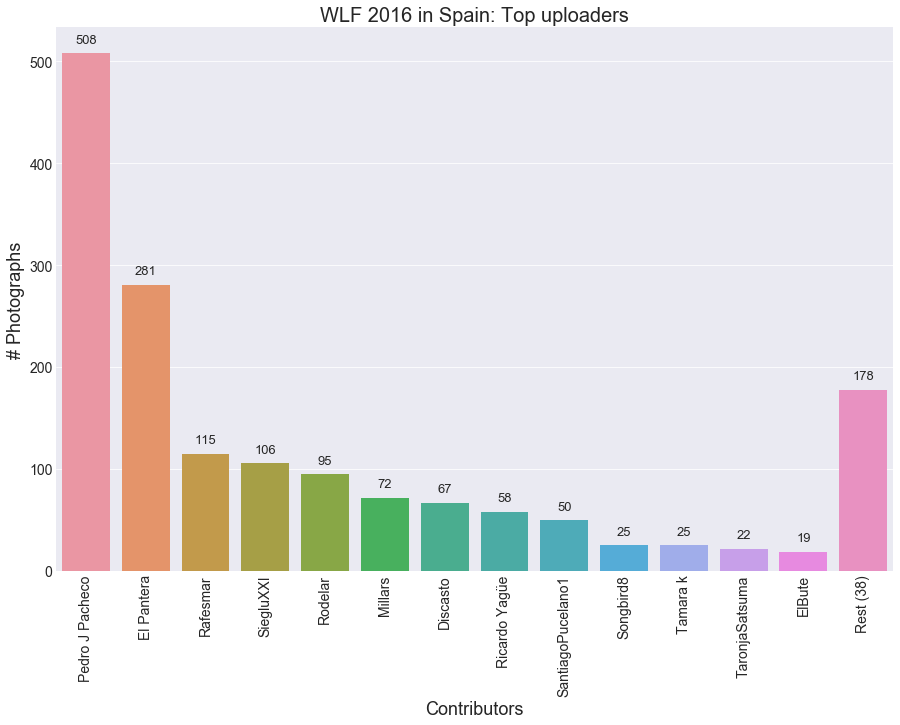

In [43]:
fig, ax = plt.subplots(figsize=figsize)

p = sns.barplot(ax=ax, x=remaining_images_per_uploader.index, y=remaining_images_per_uploader.values)
p.set_xlabel("Contributors", fontsize=18)
p.set_ylabel("# Photographs", fontsize=18)

p.set_title(label='{1} {0} in Spain: Top uploaders'.format(YEAR, TAG), fontsize=20)
p.tick_params(labelsize=14)

p.set_xticklabels(p.get_xticklabels(), rotation=90)

for patch in p.patches:
    height = patch.get_height()
    p.text(patch.get_x() + patch.get_width()/2.,
            height + 10,
            '{:1.0f}'.format(height),
            ha="center",
            fontsize=13)

upload_to_commons(p,
                  "{1} {0} in Spain - Top authors.png".format(YEAR, TAG),
                  'Top {2} contributors to {1} {0} in Spain'.format(YEAR, TAG_EXT, TOP_UPLOADERS),
                  plot_description,
                  YEAR,
                  TAG_EXT
                 )

In [44]:
images_df['uploader'].unique()

array(['Tordo12', 'Elnafe', 'Antonio Arenas', 'El Pantera',
       'Pedro J Pacheco', 'SiegluXXI', 'Rodelar', 'Gisela Dombek',
       'Dben eswiki', 'B25es', 'Millars', 'Songbird8', 'Nordentor',
       'Niv66', 'Majopegolina', 'Tamara k', 'Antonio Arenas Ramírez',
       'Marsan', 'Jovigama', 'Dbascones', 'Castellónenred',
       'Rubenholguera', 'Juan vi joan', 'Molsos', 'Usoleris', 'Mikipons',
       'Ricardo Yagüe', 'Adolfobrigido', 'Discasto', 'Bertobarc90',
       'Maryna Dymovich', 'Verbigracias', 'TaronjaSatsuma', 'Orruza1983',
       'Llapissera', 'SantiagoPucelano1', 'Jespa', 'Rafesmar',
       'Jaime Calatayud', 'Tomastt1983', 'JulioC66', 'Antonio Sánchez',
       'Mwernercasero', 'Jorgemrtz', 'Álvaro ArMo', 'ElBute',
       'Emilio Luque', 'Montgomery', 'Danielph147',
       'SEMANASANTACALLOSADESEGURA', 'Coentor'], dtype=object)

In [45]:
images_df['uploader'].unique().size

51

In [46]:
valid_images_length = len(images_df[images_df['wikidata_id'].isin(valid_festivals)].index)
valid_images_length

1588

In [47]:
images_df[images_df['wikidata_id'].isin(valid_festivals)]['wikidata_id'].unique()

array(['Q7884112', 'Q28157451', 'Q23459821', 'Q6124533', 'Q9075883',
       'Q5861740', 'Q21855013', 'Q23310069', 'Q23658017', 'Q23661528',
       'Q23660832', 'Q23663335', 'Q1143768', 'Q5861795', 'Q5970261',
       'Q23452764', 'Q17636451', 'Q23663045', 'Q815872', 'Q5752915',
       'Q5752929', 'Q5044119', 'Q26756828', 'Q3092923', 'Q21595880',
       'Q3181317', 'Q23663100', 'Q5685566', 'Q17627979', 'Q23663330',
       'Q6135210', 'Q3290365', 'Q2838024', 'Q8355038', 'Q23199370',
       'Q3045527', 'Q23458862', 'Q2886090', 'Q20105952', 'Q23657558',
       'Q23653026', 'Q23663326', 'Q2834310', 'Q23663119', 'Q5855501',
       'Q2918983', 'Q20108095', 'Q11921916', 'Q23661684', 'Q5861751',
       'Q11921892', 'Q23662679', 'Q23660809', 'Q5650710', 'Q23663151',
       'Q23660893', 'Q8961628', 'Q23199311', 'Q23663127', 'Q23657694',
       'Q3444111', 'Q20014639', 'Q23662185', 'Q23662637', 'Q13258770',
       'Q23310072', 'Q20541714', 'Q23663386', 'Q23453538', 'Q23452661',
       'Q23453336', 

In [48]:
festivals_per_uploader_df = images_df[images_df['wikidata_id'].isin(valid_festivals)].\
                                    groupby(['uploader']).\
                                    agg({"wikidata_id": pd.Series.nunique}).\
                                    sort_values('wikidata_id', ascending=False)
festivals_per_uploader = festivals_per_uploader_df["wikidata_id"]
festivals_per_uploader = festivals_per_uploader.rename('festivals')
festivals_per_uploader = festivals_per_uploader.iloc[np.lexsort([festivals_per_uploader.index, -festivals_per_uploader.values])]
festivals_per_uploader

uploader
SiegluXXI                     15
Discasto                       8
Mikipons                       7
Rodelar                        7
Pedro J Pacheco                6
Millars                        5
Orruza1983                     4
Songbird8                      3
Tamara k                       3
B25es                          2
Castellónenred                 2
Jovigama                       2
Marsan                         2
Molsos                         2
Ricardo Yagüe                  2
TaronjaSatsuma                 2
Usoleris                       2
Adolfobrigido                  1
Antonio Arenas                 1
Antonio Arenas Ramírez         1
Antonio Sánchez                1
Bertobarc90                    1
Coentor                        1
Danielph147                    1
Dbascones                      1
Dben eswiki                    1
El Pantera                     1
ElBute                         1
Elnafe                         1
Emilio Luque                   1
G

In [49]:
# THIS PARAMETER IS YEAR-DEPENDENT AND COMES FROM MANUAL INSPECTION
TOP_UPLOADERS_BY_FESTIVAL = 17

In [50]:
images_df[images_df['wikidata_id'].isin(valid_festivals)]['wikidata_id'].unique()

array(['Q7884112', 'Q28157451', 'Q23459821', 'Q6124533', 'Q9075883',
       'Q5861740', 'Q21855013', 'Q23310069', 'Q23658017', 'Q23661528',
       'Q23660832', 'Q23663335', 'Q1143768', 'Q5861795', 'Q5970261',
       'Q23452764', 'Q17636451', 'Q23663045', 'Q815872', 'Q5752915',
       'Q5752929', 'Q5044119', 'Q26756828', 'Q3092923', 'Q21595880',
       'Q3181317', 'Q23663100', 'Q5685566', 'Q17627979', 'Q23663330',
       'Q6135210', 'Q3290365', 'Q2838024', 'Q8355038', 'Q23199370',
       'Q3045527', 'Q23458862', 'Q2886090', 'Q20105952', 'Q23657558',
       'Q23653026', 'Q23663326', 'Q2834310', 'Q23663119', 'Q5855501',
       'Q2918983', 'Q20108095', 'Q11921916', 'Q23661684', 'Q5861751',
       'Q11921892', 'Q23662679', 'Q23660809', 'Q5650710', 'Q23663151',
       'Q23660893', 'Q8961628', 'Q23199311', 'Q23663127', 'Q23657694',
       'Q3444111', 'Q20014639', 'Q23662185', 'Q23662637', 'Q13258770',
       'Q23310072', 'Q20541714', 'Q23663386', 'Q23453538', 'Q23452661',
       'Q23453336', 

In [51]:
wlf_festivals_length = images_df[images_df['wikidata_id'].isin(valid_festivals)]['wikidata_id'].unique().size
wlf_festivals_length

91

[[commons:File:WLF 2016 in Spain - Top authors by festival.png]]


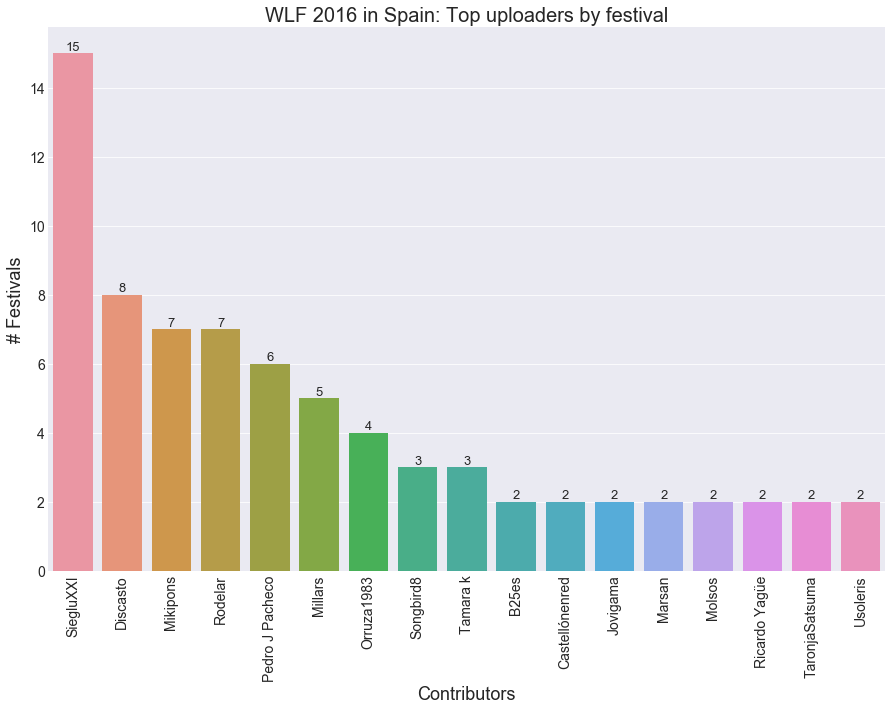

In [52]:
fig, ax = plt.subplots(figsize=figsize)

p = sns.barplot(ax=ax, 
                x=festivals_per_uploader[:TOP_UPLOADERS_BY_FESTIVAL].index, 
                y=festivals_per_uploader[:TOP_UPLOADERS_BY_FESTIVAL].values
               )
p.set_xlabel("Contributors", fontsize=18)
p.set_ylabel("# Festivals", fontsize=18)

p.set_title(label='{1} {0} in Spain: Top uploaders by festival'.format(YEAR, TAG), fontsize=20)
p.tick_params(labelsize=14)

p.set_xticklabels(p.get_xticklabels(), rotation=90)
p.yaxis.set_major_locator(MaxNLocator(integer=True))

for patch in p.patches:
    height = patch.get_height()
    p.text(patch.get_x() + patch.get_width()/2.,
            height + 0.1,
            '{:1.0f}'.format(height),
            ha="center",
            fontsize=13)

upload_to_commons(p,
                  "{1} {0} in Spain - Top authors by festival.png".format(YEAR, TAG),
                  'Top {2} contributors to {1} {0} in Spain'.format(YEAR, TAG_EXT, TOP_UPLOADERS_BY_FESTIVAL),
                  plot_description,
                  YEAR,
                  TAG_EXT
                 )

In [53]:
uploaders_df = pd.concat([festivals_per_uploader, images_per_uploader], axis=1).fillna(0)
uploaders_df.columns=['Festivals', 'Photographs']
uploaders_df['Festivals'] = uploaders_df['Festivals'].astype(int)
uploaders_df = uploaders_df.iloc[np.lexsort([uploaders_df.index, -uploaders_df['Photographs']])]
uploaders_df

,Festivals,Photographs
Pedro J Pacheco,6,508
El Pantera,1,281
Rafesmar,1,115
SiegluXXI,15,106
Rodelar,7,95
Millars,5,72
Discasto,8,67
Ricardo Yagüe,2,58
SantiagoPucelano1,1,50
Songbird8,3,25


[[commons:File:WLF 2016 in Spain - Top authors (2).png]]


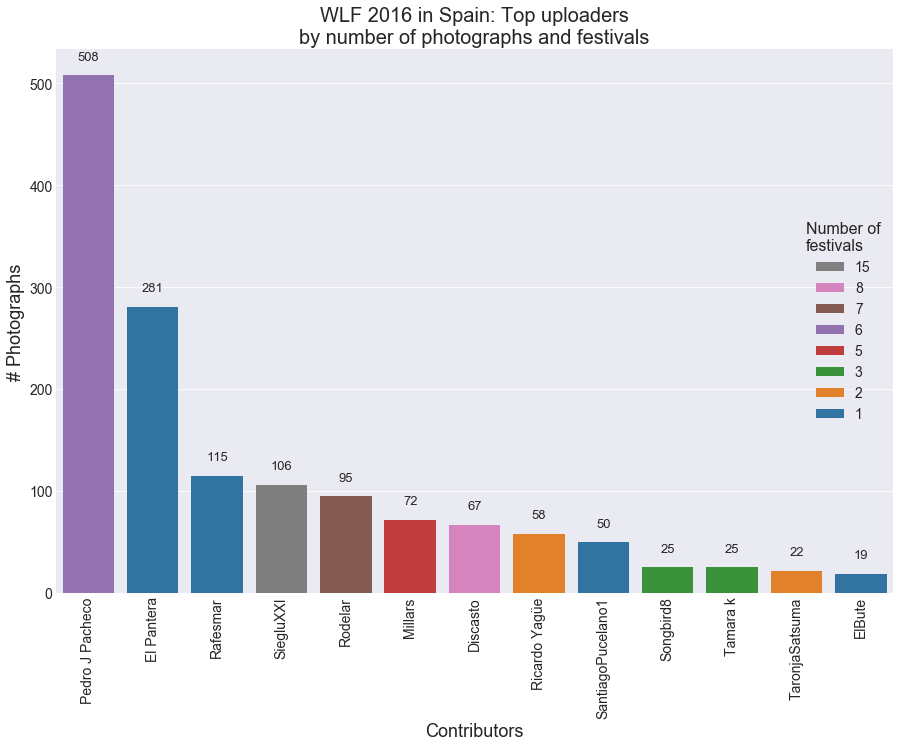

In [54]:
fig, ax = plt.subplots(figsize=figsize)

p = sns.barplot(ax=ax, 
                x=uploaders_df[:TOP_UPLOADERS].index, 
                y=uploaders_df[:TOP_UPLOADERS]['Photographs'], 
                hue=uploaders_df[:TOP_UPLOADERS]['Festivals'],
                dodge=False)
p.set_xlabel("Contributors", fontsize=18)
p.set_ylabel("# Photographs", fontsize=18)

p.set_title(label='{1} {0} in Spain: Top uploaders\nby number of photographs and festivals'.format(YEAR, TAG), fontsize=20)

p.tick_params(labelsize=14)
p.set_xticklabels(p.get_xticklabels(), rotation=90)

handles, labels = p.get_legend_handles_labels()
handles.reverse()
labels.reverse()

legend = plt.legend(loc='center right', 
                    title='Number of\nfestivals', 
                    fontsize=14,
                    labels=labels,
                    handles=handles)
plt.setp(legend.get_title(), fontsize=16)

for patch in p.patches:
    height = patch.get_height()
    if not math.isnan(height):
        p.text(patch.get_x() + patch.get_width()/2.,
                height + 15,
                '{:1.0f}'.format(height),
                ha="center",
                fontsize=13)

upload_to_commons(p,
                  "{1} {0} in Spain - Top authors (2).png".format(YEAR, TAG),
                  'Top {2} contributors to {1} {0} in Spain with contribution to festivals'.format(YEAR, TAG_EXT, TOP_UPLOADERS),
                  plot_description,
                  YEAR,
                  TAG_EXT
                 )

In [55]:
images_df['wikidata_id'].value_counts()

Q9075883     427
Q6124533     281
Q1143768     223
Q23662660     54
Q5685566      51
              33
Q8355038      33
Q5861751      29
Q9075868      23
Q23663119     22
Q26756828     21
Q23199370     20
Q17627979     19
Q23660893     18
Q23663127     16
Q23453336     14
Q23453538     14
Q9075846      14
Q23663151     14
Q23310072     14
Q23663335     14
Q5044119      13
Q7884112      12
Q23452764     11
Q23660832     11
Q23310069     11
Q5861740      10
Q23662637      9
Q8961628       8
Q23452661      8
            ... 
Q23660811      2
Q28157451      2
Q5861795       2
Q5970261       2
Q11921892      2
Q23662985      2
Q2886090       1
Q5836853       1
Q829919        1
Q3092923       1
Q23662185      1
Q3290365       1
Q21483881      1
Q2838024       1
Q9066149       1
Q23663386      1
Q23662787      1
Q6135210       1
Q5752861       1
Q3444111       1
Q20105952      1
Q20541714      1
Q20014639      1
Q23657558      1
Q17636451      1
Q6124477       1
Q5963246       1
Q13258770     

In [56]:
# THIS IS YEAR-DEPENDENT
images_df[images_df["campaign"] == "autumn"]['wikidata_id'].value_counts()

Q1143768     89
Q5685566     51
Q26756828    21
Q23199370    20
Q17627979    19
Q23663151    14
Q23310072    14
Q7884112     12
Q23310069    11
Q23660832    11
Q23662637     9
Q23661684     7
Q23663045     7
              7
Q23661528     6
Q23660809     6
Q9075874      5
Q23662679     5
Q2918983      4
Q23459821     4
Q21855013     4
Q9075868      4
Q23452764     4
Q23658046     4
Q4896555      3
Q11921916     3
Q23657694     3
Q23663326     3
Q5752929      3
Q9075846      2
Q23658047     2
Q23660811     2
Q28157451     2
Q23658017     2
Q5970261      2
Q17636451     1
Q6135210      1
Q23662787     1
Q5836853      1
Q3444111      1
Q23662185     1
Q5752861      1
Q5963246      1
Q20541714     1
Q20014639     1
Name: wikidata_id, dtype: int64

In [57]:
# THIS IS YEAR-DEPENDENT
images_df[images_df["campaign"] == "summer"]['wikidata_id'].value_counts()

Q8355038     29
Q5861751     29
Q23452764     7
Q23458862     4
Name: wikidata_id, dtype: int64

In [58]:
# THIS IS YEAR-DEPENDENT
images_df[images_df["campaign"] == "spring"]['wikidata_id'].value_counts()

Q9075883     427
Q6124533     281
Q1143768     134
Q23662660     54
              26
Q23663119     22
Q9075868      19
Q23660893     18
Q23663127     16
Q23453336     14
Q23453538     14
Q9075846      12
Q23663335     11
Q5861740      10
Q8961628       8
Q23452661      8
Q2834310       8
Q23199311      7
Q23663100      6
Q23453824      6
Q3181317       5
Q23657671      4
Q23653026      4
Q23663330      4
Q8355038       4
Q5650710       3
Q20108095      3
Q11921892      2
Q11921915      2
Q3045527       2
Q21483881      1
Q3290365       1
Q23663386      1
Q20105952      1
Q6124477       1
Q2918983       1
Q23657558      1
Q9066149       1
Q2886090       1
Q2838024       1
Q829919        1
Q13258770      1
Name: wikidata_id, dtype: int64

In [59]:
# THIS IS YEAR-DEPENDENT
upload_ts = images_df[images_df['campaign'] == 'autumn']['image_title'].resample('d').count()
upload_ts[datetime(YEAR, 12, 5)] = upload_ts[datetime(YEAR, 12, 5)] + upload_ts[datetime(YEAR, 12, 6)]
upload_ts.drop(datetime(YEAR, 12, 6), inplace=True)
upload_ts = pd.Series([0]*21, index=pd.date_range(datetime(YEAR, 11, 25), periods=21, freq='D')) + upload_ts
upload_ts = upload_ts.fillna(0).astype(int)
upload_ts

2016-11-25      7
2016-11-26      0
2016-11-27      0
2016-11-28      0
2016-11-29     25
2016-11-30      0
2016-12-01      1
2016-12-02     18
2016-12-03      6
2016-12-04      4
2016-12-05     39
2016-12-06      0
2016-12-07    141
2016-12-08     19
2016-12-09     12
2016-12-10     75
2016-12-11      0
2016-12-12      0
2016-12-13     12
2016-12-14     10
2016-12-15      6
dtype: int32

[[commons:File:WLF 2016 in Spain - Uploads by day (Autumn campaign).png]]


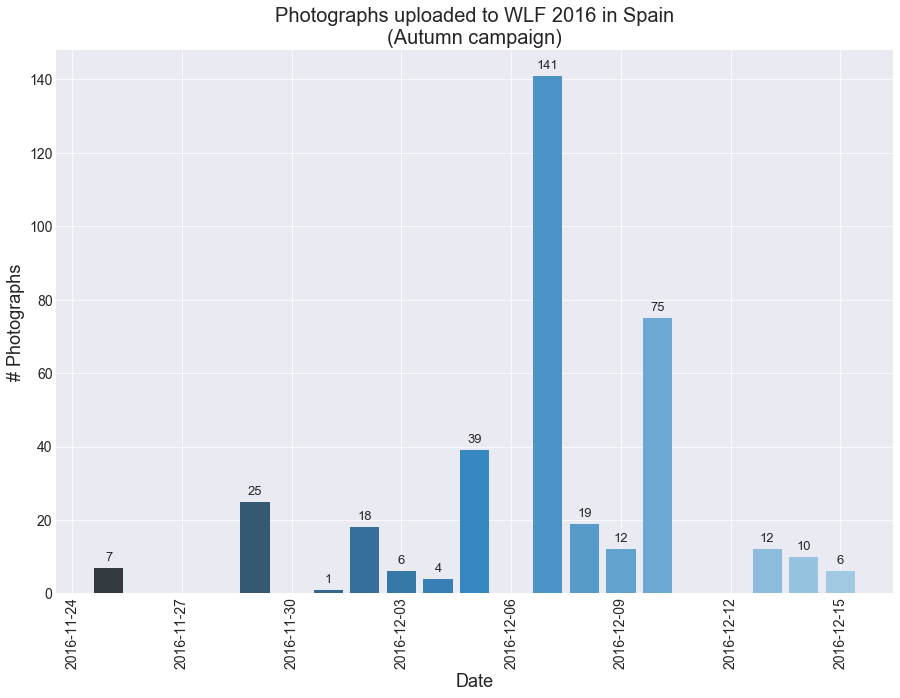

In [60]:
# THIS IS YEAR-DEPENDENT
fig, ax = plt.subplots(figsize=figsize)

p = ax.bar(upload_ts.index.to_pydatetime(), 
       upload_ts.values,
       color=sns.color_palette("Blues_d", 21))
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_xlabel('Date', fontsize=18)
ax.set_ylabel("# Photographs", fontsize=18)
ax.set_title(label='Photographs uploaded to {1} {0} in Spain\n(Autumn campaign)'.format(YEAR, TAG), fontsize=20)

ax.tick_params(labelsize=14)
plt.xticks(rotation=90)

for patch in ax.patches:
    height = patch.get_height()
    if height > 0 :
        ax.text(patch.get_x() + patch.get_width()/2.,
                height + 2,
                '{:1.0f}'.format(height),
                ha="center",
                fontsize=13)

upload_to_commons(plt,
                  "{1} {0} in Spain - Uploads by day (Autumn campaign).png".format(YEAR, TAG),
                  'Images uploaded to {1} {0} in Spain (Autumn campaign) by day'.format(YEAR, TAG),
                  plot_description,
                  YEAR,
                  TAG_EXT
                 )

In [61]:
# THIS IS YEAR-DEPENDENT
upload_ts = images_df[images_df['campaign'] == 'spring']['image_title'].resample('d').count()
upload_ts = pd.Series([0]*30, index=pd.date_range(datetime(YEAR, 4, 1), periods=30, freq='D')) + upload_ts
upload_ts = upload_ts.fillna(0).astype(int)
upload_ts

2016-04-01     87
2016-04-02     63
2016-04-03     38
2016-04-04     24
2016-04-05      9
2016-04-06      0
2016-04-07     29
2016-04-08     54
2016-04-09     14
2016-04-10     71
2016-04-11      8
2016-04-12     13
2016-04-13      8
2016-04-14      4
2016-04-15      2
2016-04-16    114
2016-04-17     22
2016-04-18     19
2016-04-19      4
2016-04-20      0
2016-04-21     23
2016-04-22     12
2016-04-23      0
2016-04-24      5
2016-04-25     51
2016-04-26      0
2016-04-27     90
2016-04-28      4
2016-04-29    126
2016-04-30    252
Freq: D, dtype: int32

[[commons:File:WLF 2016 in Spain - Uploads by day (Spring campaign).png]]


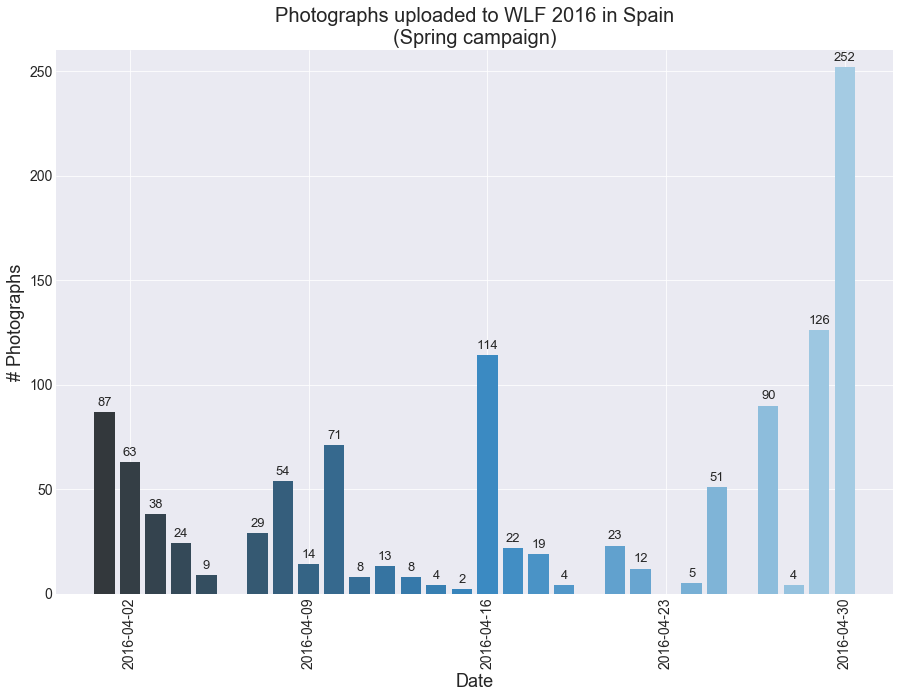

In [62]:
# THIS IS YEAR-DEPENDENT
fig, ax = plt.subplots(figsize=figsize)

p = ax.bar(upload_ts.index.to_pydatetime(), 
       upload_ts.values,
       color=sns.color_palette("Blues_d", 30))
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_xlabel('Date', fontsize=18)
ax.set_ylabel("# Photographs", fontsize=18)
ax.set_title(label='Photographs uploaded to {1} {0} in Spain\n(Spring campaign)'.format(YEAR, TAG), fontsize=20)
ax.set_ylim([0, 260])

ax.tick_params(labelsize=14)
plt.xticks(rotation=90)

for patch in ax.patches:
    height = patch.get_height()
    if height > 0 :
        ax.text(patch.get_x() + patch.get_width()/2.,
                height + 3,
                '{:1.0f}'.format(height),
                ha="center",
                fontsize=13)

upload_to_commons(plt,
                  "{1} {0} in Spain - Uploads by day (Spring campaign).png".format(YEAR, TAG),
                  'Images uploaded to {1} {0} in Spain (Spring campaign) by day'.format(YEAR, TAG),
                  plot_description,
                  YEAR,
                  TAG_EXT
                 )

In [63]:
images_extended_df = pd.merge(images_df, festivals_df, on='wikidata_id', how='left')
len(images_extended_df.index)

1621

In [64]:
valid_images_per_uploader = images_df[images_df['wikidata_id'].isin(valid_festivals)]['uploader'].value_counts()
valid_images_per_uploader = valid_images_per_uploader.rename('valid_images')
valid_images_per_uploader = valid_images_per_uploader.iloc[np.lexsort([valid_images_per_uploader.index, -valid_images_per_uploader.values])]
valid_images_per_uploader

Pedro J Pacheco               508
El Pantera                    281
Rafesmar                      115
SiegluXXI                     106
Rodelar                        73
Millars                        72
Discasto                       63
Ricardo Yagüe                  58
SantiagoPucelano1              50
Songbird8                      25
Tamara k                       25
TaronjaSatsuma                 22
ElBute                         19
Castellónenred                 16
Mikipons                       13
Coentor                        12
Tordo12                        12
Orruza1983                     10
Antonio Sánchez                 9
Jespa                           8
Majopegolina                    7
Marsan                          7
Nordentor                       7
Dben eswiki                     6
B25es                           5
Maryna Dymovich                 5
Molsos                          5
Adolfobrigido                   4
Antonio Arenas                  4
Emilio Luque  

In [65]:
festival_list_per_uploader = images_extended_df[images_extended_df['wikidata_id'].isin(valid_festivals)]\
                                               .groupby('uploader')['wikidata_id']\
                                               .apply(set)\
                                               .apply(lambda x: filter(None, x))\
                                               .apply(lambda x: expand_itemid(x))\
                                               .rename('festival_list', inplace=True)
festival_list_per_uploader

uploader
Adolfobrigido                 [{'itemid': 'Q8355038', 'category': 'Descenso ...
Antonio Arenas                [{'itemid': 'Q23459821', 'category': 'Carnival...
Antonio Arenas Ramírez        [{'itemid': 'Q5752915', 'category': 'Carnival ...
Antonio Sánchez               [{'itemid': 'Q23662637', 'category': 'Festes d...
B25es                         [{'itemid': 'Q1143768', 'category': 'Falles de...
Bertobarc90                   [{'itemid': 'Q2886090', 'category': 'Entierro ...
Castellónenred                [{'itemid': 'Q1143768', 'category': 'Falles de...
Coentor                       [{'itemid': 'Q9075846', 'category': 'Setmana S...
Danielph147                   [{'itemid': 'Q6124477', 'category': 'Holy Week...
Dbascones                      [{'itemid': 'Q3181317', 'category': 'La Mercè'}]
Dben eswiki                   [{'itemid': 'Q23661528', 'category': 'Festa do...
Discasto                      [{'itemid': 'Q5752861', 'category': 'Carnivals...
El Pantera                    [

In [66]:
authors_df = pd.concat([images_per_uploader, valid_images_per_uploader, festivals_per_uploader, festival_list_per_uploader], axis=1)\
               .sort_values(by='images', ascending=False)\
               .reset_index()\
               .rename(columns = {'index': 'contestant'})

authors_df[['images', 'valid_images', 'festivals']] = authors_df[['images', 'valid_images', 'festivals']]\
                                                                        .fillna(0)\
                                                                        .astype('int')

authors_df = authors_df.iloc[np.lexsort([authors_df['contestant'], -authors_df['images']])]
authors_df['registration_string'] = authors_df['contestant'].map(lambda x: get_registration_time(x))
authors_df['festival_list'] = authors_df['festival_list'].map(lambda x: decode_list(x))
authors_df

,contestant,images,valid_images,festivals,festival_list,registration_string
0,Pedro J Pacheco,508,508,6,"[{'itemid': 'Q3092923', 'category': 'Carthagin...",2011-07-17
1,El Pantera,281,281,1,"[{'itemid': 'Q6124533', 'category': 'Holy Week...",2007-04-07
2,Rafesmar,115,115,1,"[{'itemid': 'Q1143768', 'category': 'Falles de...",2013-09-21
3,SiegluXXI,106,106,15,"[{'itemid': 'Q21855013', 'category': 'Antruejo...",2015-12-26
4,Rodelar,95,73,7,"[{'itemid': 'Q23458862', 'category': 'Dos de M...",2008-12-03
5,Millars,72,72,5,"[{'itemid': 'Q23663100', 'category': 'Cavalcad...",2007-04-04
6,Discasto,67,63,8,"[{'itemid': 'Q5752861', 'category': 'Carnivals...",2014-03-02
7,Ricardo Yagüe,58,58,2,"[{'itemid': 'Q8355038', 'category': 'Descenso ...",2016-01-20
8,SantiagoPucelano1,50,50,1,"[{'itemid': 'Q1143768', 'category': 'Falles de...",2016-12-10
10,Songbird8,25,25,3,"[{'itemid': 'Q1143768', 'category': 'Falles de...",2016-11-29


In [67]:
images_per_festival = images_extended_df[images_extended_df['wikidata_id'].isin(valid_festivals)]['wikidata_id'].value_counts()
images_per_festival

Q9075883     427
Q6124533     281
Q1143768     223
Q23662660     54
Q5685566      51
Q8355038      33
Q5861751      29
Q9075868      23
Q23663119     22
Q26756828     21
Q23199370     20
Q17627979     19
Q23660893     18
Q23663127     16
Q23453538     14
Q23663335     14
Q23453336     14
Q23310072     14
Q23663151     14
Q9075846      14
Q5044119      13
Q7884112      12
Q23660832     11
Q23310069     11
Q23452764     11
Q5861740      10
Q23662637      9
Q2834310       8
Q23452661      8
Q8961628       8
            ... 
Q11921892      2
Q23658047      2
Q5970261       2
Q3045527       2
Q23662985      2
Q23660811      2
Q17636451      1
Q5836853       1
Q829919        1
Q3092923       1
Q23662185      1
Q21483881      1
Q9066149       1
Q5752861       1
Q2886090       1
Q23662787      1
Q6124477       1
Q6135210       1
Q13258770      1
Q20014639      1
Q20105952      1
Q3444111       1
Q23657558      1
Q3290365       1
Q5963246       1
Q5752915       1
Q5855501       1
Q2838024      

In [68]:
# THIS PARAMETER IS YEAR-DEPENDENT AND COMES FROM MANUAL INSPECTION
# May be set to the number of festivals with more than 15 pictures
TOP_FESTIVALS = 14

In [69]:
images_per_festival_df = pd.DataFrame(data=images_per_festival).reset_index()
images_per_festival_df.rename(columns={'index': 'wikidata_id', 'wikidata_id': 'count'}, inplace=True)

In [70]:
images_per_festival_df = pd.merge(images_per_festival_df, festivals_df, on='wikidata_id')[['count', 'wikidata_id', 'category', 'aut_com', 'latitude', 'longitude']].fillna('')
images_per_festival_df = images_per_festival_df.iloc[np.lexsort([images_per_festival_df['category'], -images_per_festival_df['count']])]
images_per_festival_df['category'] = images_per_festival_df['category'].map(lambda x: x.replace('_', ' '))
images_per_festival_df.head()

,count,wikidata_id,category,aut_com,latitude,longitude
0,427,Q9075883,Holy Week in Málaga,Andalusia,36.716667,-4.416667
1,281,Q6124533,Holy Week in Jerez de la Frontera,Andalusia,36.700000,-6.116667
2,223,Q1143768,Falles de València,Valencian Community,39.466667,-0.375000
3,54,Q23662660,"Festes de Sant Cristòfol de ses Corregudes, es...",Balearic Islands,39.945278,4.048889
4,51,Q5685566,Holy Week in Murcia,Region of Murcia,37.986111,-1.130278


In [71]:
images_per_festival_df['dup_index'] = images_per_festival_df.groupby(['latitude', 'longitude'])['latitude'].transform('idxmin')    
images_per_festival_df['dup'] = images_per_festival_df.duplicated(subset=['dup_index'])
images_per_festival_df.head()

,count,wikidata_id,category,aut_com,latitude,longitude,dup_index,dup
0,427,Q9075883,Holy Week in Málaga,Andalusia,36.716667,-4.416667,0.0,False
1,281,Q6124533,Holy Week in Jerez de la Frontera,Andalusia,36.700000,-6.116667,1.0,False
2,223,Q1143768,Falles de València,Valencian Community,39.466667,-0.375000,2.0,False
3,54,Q23662660,"Festes de Sant Cristòfol de ses Corregudes, es...",Balearic Islands,39.945278,4.048889,3.0,False
4,51,Q5685566,Holy Week in Murcia,Region of Murcia,37.986111,-1.130278,4.0,False


In [72]:
images_per_festival_df['coordinates'] = images_per_festival_df.apply(shaker, axis=1)
images_per_festival_df[['latitude', 'longitude']] = images_per_festival_df['coordinates'].apply(pd.Series)
images_per_festival_df.head()

,count,wikidata_id,category,aut_com,latitude,longitude,dup_index,dup,coordinates
0,427,Q9075883,Holy Week in Málaga,Andalusia,36.716667,-4.416667,0.0,False,"(36.71666666666667, -4.416666666666667)"
1,281,Q6124533,Holy Week in Jerez de la Frontera,Andalusia,36.700000,-6.116667,1.0,False,"(36.7, -6.116666666666666)"
2,223,Q1143768,Falles de València,Valencian Community,39.466667,-0.375000,2.0,False,"(39.46666666666667, -0.375)"
3,54,Q23662660,"Festes de Sant Cristòfol de ses Corregudes, es...",Balearic Islands,39.945278,4.048889,3.0,False,"(39.945277777777775, 4.0488888888888885)"
4,51,Q5685566,Holy Week in Murcia,Region of Murcia,37.986111,-1.130278,4.0,False,"(37.986111111111114, -1.1302777777777775)"


In [73]:
images_per_festival_df['geojson'] = images_per_festival_df.apply(lambda row: to_geojson(row), axis=1)

In [74]:
features = images_per_festival_df['geojson'].tolist()
feature_collection = FeatureCollection(features)
dump = geojson.dumps(feature_collection, ensure_ascii=False, indent=2)
#print(dump)

In [75]:
festivals_per_autcom = images_per_festival_df.groupby(['aut_com']).\
                                              count().\
                                              sort_values(by='count', ascending=False).\
                                              reset_index()[['aut_com', 'count']]
festivals_per_autcom['aut_com'] = festivals_per_autcom['aut_com'].map(lambda x: wrap_label(x, 14))
festivals_per_autcom

,aut_com,count
0,Valencian\nCommunity,21
1,Castile and\nLeón,17
2,Community of\nMadrid,8
3,Region of\nMurcia,8
4,Andalusia,6
5,Balearic\nIslands,6
6,Catalonia,6
7,Castile-La\nMancha,4
8,Galicia,4
9,Canary Islands,3


In [76]:
aut_coms = len(festivals_per_autcom.index)
aut_coms

16

In [77]:
# THIS IS YEAR-DEPENDEND AND RELIES ON MANUAL INSPECTION
remaining_autcoms = pd.DataFrame(data=[{'aut_com': 'La Rioja', 'count':0}],
                                 index=[16])
remaining_autcoms

,aut_com,count
16,La Rioja,0


In [78]:
festivals_per_autcom = festivals_per_autcom.append(remaining_autcoms)
festivals_per_autcom

,aut_com,count
0,Valencian\nCommunity,21
1,Castile and\nLeón,17
2,Community of\nMadrid,8
3,Region of\nMurcia,8
4,Andalusia,6
5,Balearic\nIslands,6
6,Catalonia,6
7,Castile-La\nMancha,4
8,Galicia,4
9,Canary Islands,3


[[commons:File:WLF 2016 in Spain - Festivals per autonomous community.png]]


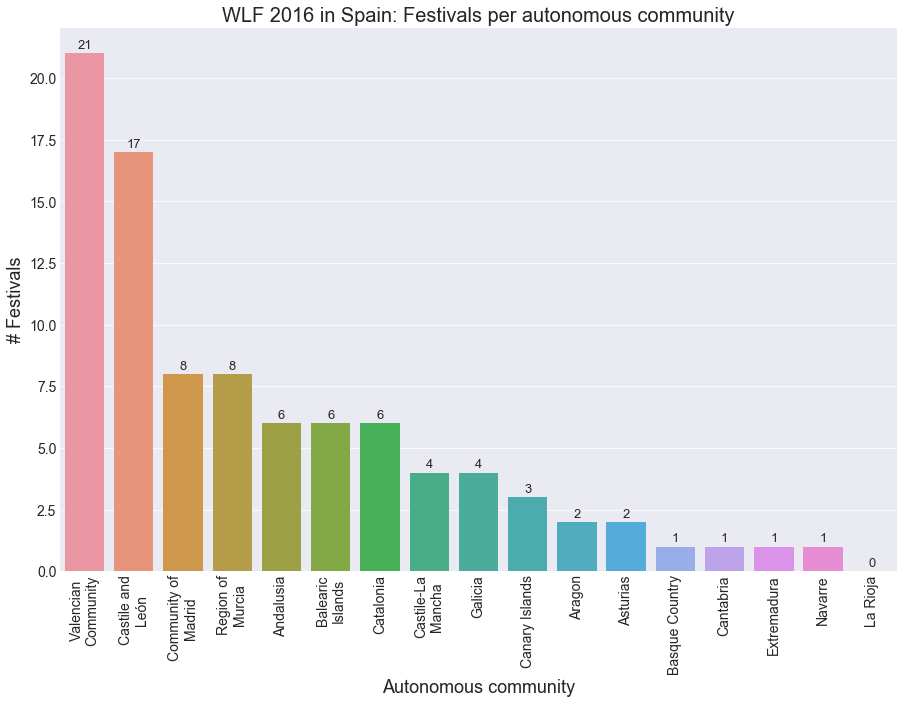

In [79]:
fig, ax = plt.subplots(figsize=figsize)

p = sns.barplot(ax=ax, data=festivals_per_autcom, x='aut_com', y='count')
p.set_xlabel("Autonomous community", fontsize=18)
p.set_ylabel("# Festivals", fontsize=18)

p.set_title(label='{1} {0} in Spain: Festivals per autonomous community'.format(YEAR, TAG), fontsize=20)
p.tick_params(labelsize=14)

p.set_xticklabels(p.get_xticklabels(), rotation=90)

for patch in p.patches:
    height = patch.get_height()
    p.text(patch.get_x() + patch.get_width()/2.,
            height + 0.2,
            '{:1.0f}'.format(height),
            ha="center",
            fontsize=13)

upload_to_commons(p,
                  "{1} {0} in Spain - Festivals per autonomous community.png".format(YEAR, TAG),
                  'Catalogued festivals per autonomous community in {1} {0} in Spain'.format(YEAR, TAG_EXT),
                  plot_description,
                  YEAR,
                  TAG_EXT
                 )

In [80]:
compact_images_per_festival = images_per_festival_df[:TOP_FESTIVALS][['count', 'category']]
compact_images_per_festival = compact_images_per_festival.iloc[np.lexsort([compact_images_per_festival['category'], -compact_images_per_festival['count']])]
compact_images_per_festival

,count,category
0,427,Holy Week in Málaga
1,281,Holy Week in Jerez de la Frontera
2,223,Falles de València
3,54,"Festes de Sant Cristòfol de ses Corregudes, es..."
4,51,Holy Week in Murcia
5,33,Descenso del Sella
6,29,Fiesta del Asturcón
7,23,"Holy Week in Córdoba, Spain"
8,22,Falles of Burriana
9,21,Romería de Nuestra Señora de la Virgen del Vil...


In [81]:
images_per_festival_df[TOP_FESTIVALS:].sum()['count']

351

In [82]:
len(images_per_festival_df[TOP_FESTIVALS:].index)

77

In [83]:
others_row = pd.DataFrame(data={'category': 'Other festivals ({0})'.format(len(images_per_festival_df[TOP_FESTIVALS:].index)),
                                'count': images_per_festival_df[TOP_FESTIVALS:].sum()['count']}, 
                          index=[TOP_FESTIVALS+1])

In [84]:
no_id_row = pd.DataFrame(data={'category': 'Unknown/invalid',
                               'count': len(images_extended_df[images_extended_df['wikidata_id'] == ''].index)}, 
                         index=[TOP_FESTIVALS+2])

In [85]:
compact_images_per_festival = compact_images_per_festival.append(others_row)
compact_images_per_festival = compact_images_per_festival.append(no_id_row)
compact_images_per_festival['category'] = compact_images_per_festival['category'].map(lambda x: wrap_label(x))
compact_images_per_festival

,category,count
0,Holy Week in Málaga,427
1,Holy Week in Jerez de la\nFrontera,281
2,Falles de València,223
3,"Festes de Sant Cristòfol de\nses Corregudes, e...",54
4,Holy Week in Murcia,51
5,Descenso del Sella,33
6,Fiesta del Asturcón,29
7,"Holy Week in Córdoba, Spain",23
8,Falles of Burriana,22
9,Romería de Nuestra Señora de\nla Virgen del Vi...,21


[[commons:File:WLF 2016 in Spain - Top festivals.png]]


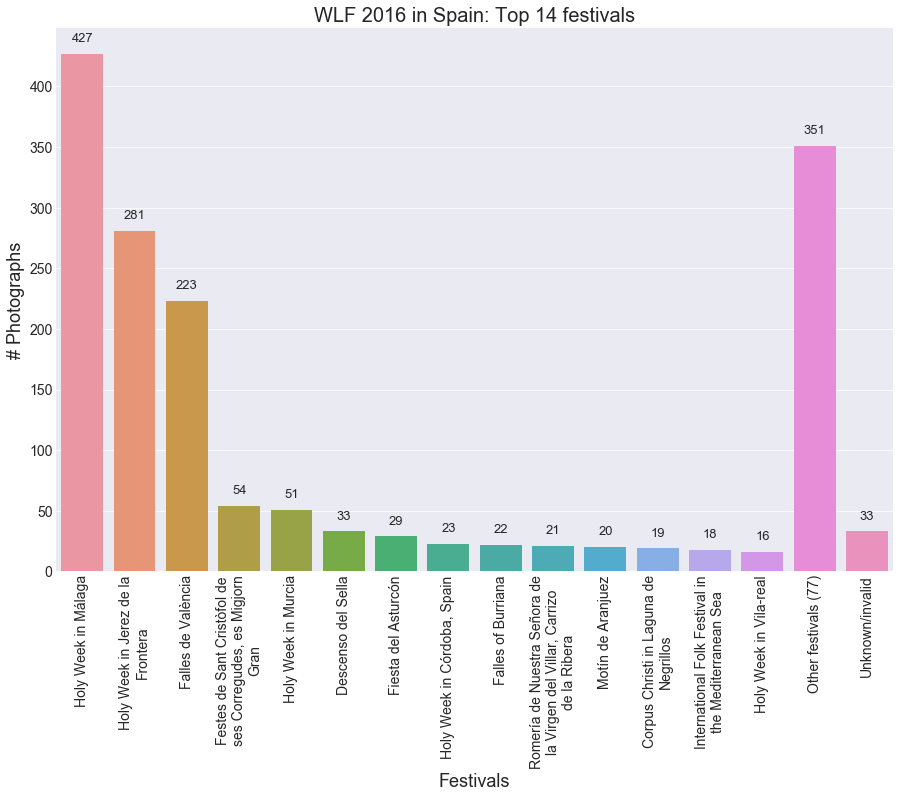

In [86]:
fig, ax = plt.subplots(figsize=figsize)

p = sns.barplot(ax=ax, data=compact_images_per_festival, x='category', y='count')
p.set_xlabel("Festivals", fontsize=18)
p.set_ylabel("# Photographs", fontsize=18)

p.set_title(label='{1} {0} in Spain: Top 14 festivals'.format(YEAR, TAG), fontsize=20)
p.tick_params(labelsize=14)

p.set_xticklabels(p.get_xticklabels(), rotation=90)

for patch in p.patches:
    height = patch.get_height()
    p.text(patch.get_x() + patch.get_width()/2.,
            height + 10,
            '{:1.0f}'.format(height),
            ha="center",
            fontsize=13)

upload_to_commons(p,
                  "{1} {0} in Spain - Top festivals.png".format(YEAR, TAG),
                  'Top 12 festivals in {1} {0} in Spain'.format(YEAR, TAG_EXT),
                  plot_description,
                  YEAR,
                  TAG_EXT
                 )

In [87]:
images_per_autcom = images_per_festival_df.groupby(['aut_com']).\
                     sum().\
                     sort_values(by='count', ascending=False).\
                     reset_index()
images_per_autcom = images_per_autcom.append(remaining_autcoms)
images_per_autcom

,aut_com,count,dup,dup_index,latitude,longitude
0,Andalusia,741,0.0,174.0,222.516667,-27.716389
1,Valencian Community,356,5.0,822.0,827.132744,-7.817509
2,Castile and León,112,3.0,679.0,721.903056,-93.048056
3,Region of Murcia,98,3.0,189.0,302.720000,-10.773333
4,Community of Madrid,78,0.0,241.0,322.521111,-28.843333
5,Balearic Islands,74,0.0,254.0,239.626111,24.625556
6,Asturias,62,0.0,11.0,43.413611,-5.275278
7,Canary Islands,25,0.0,90.0,84.591389,-47.295278
8,Catalonia,13,0.0,394.0,248.934167,11.504444
9,Castile-La Mancha,10,0.0,272.0,159.717222,-12.269444


[[commons:File:WLF 2016 in Spain - Photographs per autonomous community.png]]


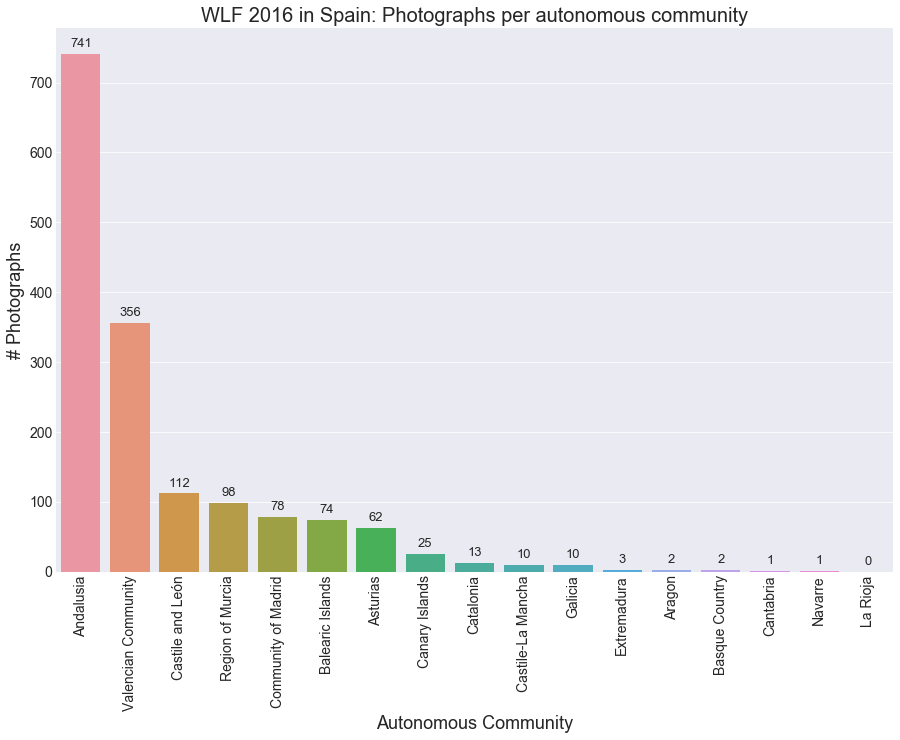

In [88]:
fig, ax = plt.subplots(figsize=figsize)

p = sns.barplot(ax=ax, data=images_per_autcom, x='aut_com', y='count')
p.set_xlabel("Autonomous Community", fontsize=18)
p.set_ylabel("# Photographs", fontsize=18)

p.set_title(label='{1} {0} in Spain: Photographs per autonomous community'.format(YEAR, TAG), fontsize=20)
p.tick_params(labelsize=14)

p.set_xticklabels(p.get_xticklabels(), rotation=90)

for patch in p.patches:
    height = patch.get_height()
    p.text(patch.get_x() + patch.get_width()/2.,
            height + 10,
            '{:1.0f}'.format(height),
            ha="center",
            fontsize=13)

upload_to_commons(p,
                  "{1} {0} in Spain - Photographs per autonomous community.png".format(YEAR, TAG),
                  'Photographs per autonomous community in {1} {0} in Spain'.format(YEAR, TAG_EXT),
                  plot_description,
                  YEAR,
                  TAG_EXT
                 )

In [89]:
# usage management
n = 5 # number of images to ask for each time. Must have a lower value in heavy-used scenarios
list_df = [images_df[i:i+n] for i in range(0, images_df.shape[0], n)]
usage_dict = {}

counter = 0
for df in list_df :
    query_string_items = list()
    for _, row in df.iterrows():
        title = 'File:{0}'.format(row["image_title"])
        query_string_items.append(title)
    raw_api_query_string = '|'.join(query_string_items)
    MW_API_QUERY_STRING["titles"] = raw_api_query_string
    
    r = requests.post(MW_API_BASE_URL, data=urlencode(MW_API_QUERY_STRING))
    response = r.text

    try:
        response_dict = json.loads(response)
        for _, value in response_dict["query"]["pages"].items():
            uses_dict = value['globalusage']
            tuples = [(item['wiki'], 1) for item in uses_dict if (item['ns'] in VALID_NAMESPACES)]
            summary = [reduce(lambda x, y: (x[0], x[1]+y[1]), group) for _, group in groupby(sorted(tuples), key=itemgetter(0))]
            if len(summary) > 0 :
                counter +=1
                title = value['title'].replace('File:', '')
                summary_dict = {tuple[0]: tuple[1] for tuple in summary}
                usage_dict.update({title: summary_dict})
    except :
        print ('Error found')
        pass

In [90]:
# unique images used
usage_df = pd.DataFrame(usage_dict).transpose()
total_unique=usage_df.count(axis=1).count()
total_unique

213

In [91]:
# unique images used with campaign indicator
usage_campaign_df = pd.merge(usage_df.reset_index().rename(columns={'index': 'image_title'}),
                             images_df[['image_title', 'campaign']], 
                             how='inner', 
                             on='image_title')

In [92]:
# summary table
usages_df = pd.concat([usage_df.sum(), usage_df.count()], axis=1)
usages_df.columns = ['usages', 'unique']
usages_df['usages'] = usages_df['usages'].astype(int)
usages_df.sort_values(by=['unique'], axis=0, ascending=False, inplace=True)
usages_df['name'] = usages_df.index
usages_df['name'] = usages_df['name'].map(get_project_name)
usages_df.set_index(['name'], inplace=True)
usages_df = usages_df.iloc[np.lexsort([usages_df.index, -usages_df['unique']])]
usages_df

,usages,unique
name,,
Spanish Wikipedia,178,149
Catalan Wikipedia,42,35
Wikidata,34,34
English Wikipedia,26,26
French Wikipedia,8,6
Galician Wikipedia,4,4
Meta,8,4
Outreach,6,3
Portuguese Wikipedia,3,3


In [93]:
# THIS PARAMETER IS YEAR-DEPENDENT AND COMES FROM MANUAL INSPECTION
# May be set to the number of projects with more than 1 picture
TOP_PROJECTS = 11

In [94]:
remaining_df = pd.DataFrame(usages_df.iloc[TOP_PROJECTS:].sum()).transpose()
other_projects_num = len(usages_df.index)-TOP_PROJECTS
remaining_df.index=['Other projects ({})'.format(other_projects_num)]
top_df = usages_df.iloc[:TOP_PROJECTS]
reduced_usages_df = top_df.append(remaining_df)
reduced_usages_df

,usages,unique
Spanish Wikipedia,178,149
Catalan Wikipedia,42,35
Wikidata,34,34
English Wikipedia,26,26
French Wikipedia,8,6
Galician Wikipedia,4,4
Meta,8,4
Outreach,6,3
Portuguese Wikipedia,3,3
Basque Wikipedia,2,2


[[commons:File:WLF 2016 in Spain - Unique photographs used in WMF projects.png]]


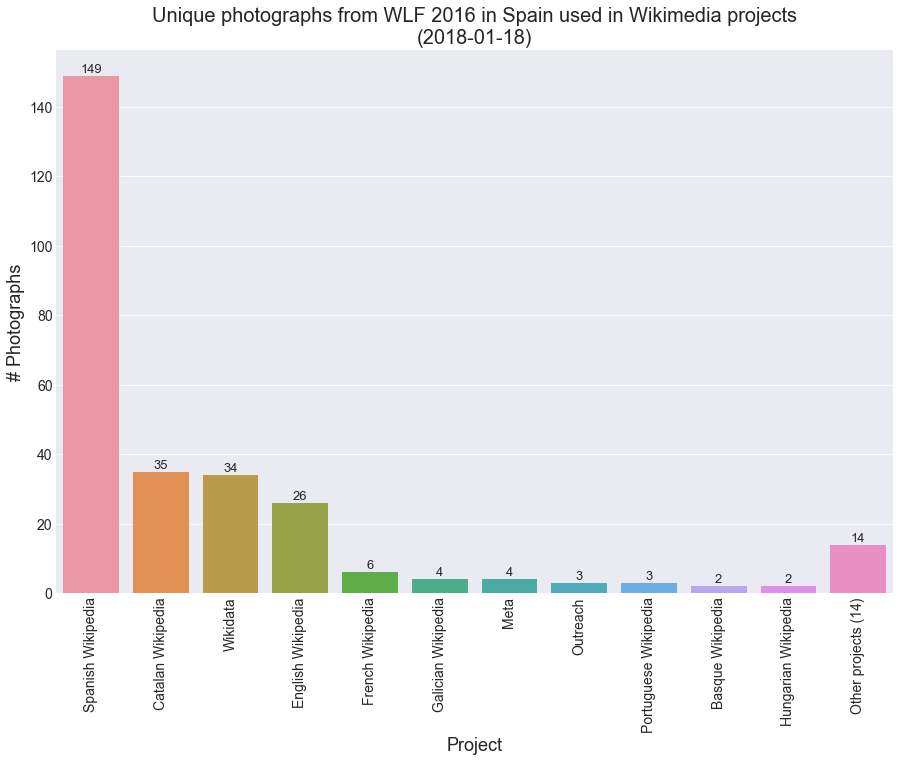

In [95]:
fig, ax = plt.subplots(figsize=figsize)

p = sns.barplot(ax=ax, x='index', y='unique', data=reduced_usages_df.reset_index())
p.set_xlabel("Project", fontsize=18)
p.set_ylabel("# Photographs", fontsize=18)

p.set_title(label='Unique photographs from {2} {0} in Spain used in Wikimedia projects\n({1})'.format(YEAR, now, TAG), fontsize=20)
p.tick_params(labelsize=14)

p.set_xticklabels(p.get_xticklabels(), rotation=90)

for patch in p.patches:
    height = patch.get_height()
    p.text(patch.get_x() + patch.get_width()/2.,
            height + 1,
            '{:1.0f}'.format(height),
            ha="center",
            fontsize=13)

upload_to_commons(p,
                  "{1} {0} in Spain - Unique photographs used in WMF projects.png".format(YEAR, TAG),
                  'Unique photographs from {1} {0} in Spain used in WMF projects: top 12 projects'.format(YEAR, TAG_EXT),
                  plot_description,
                  YEAR,
                  TAG_EXT
                 )

[[commons:File:WLF 2016 in Spain - Uses of photographs in WMF projects.png]]


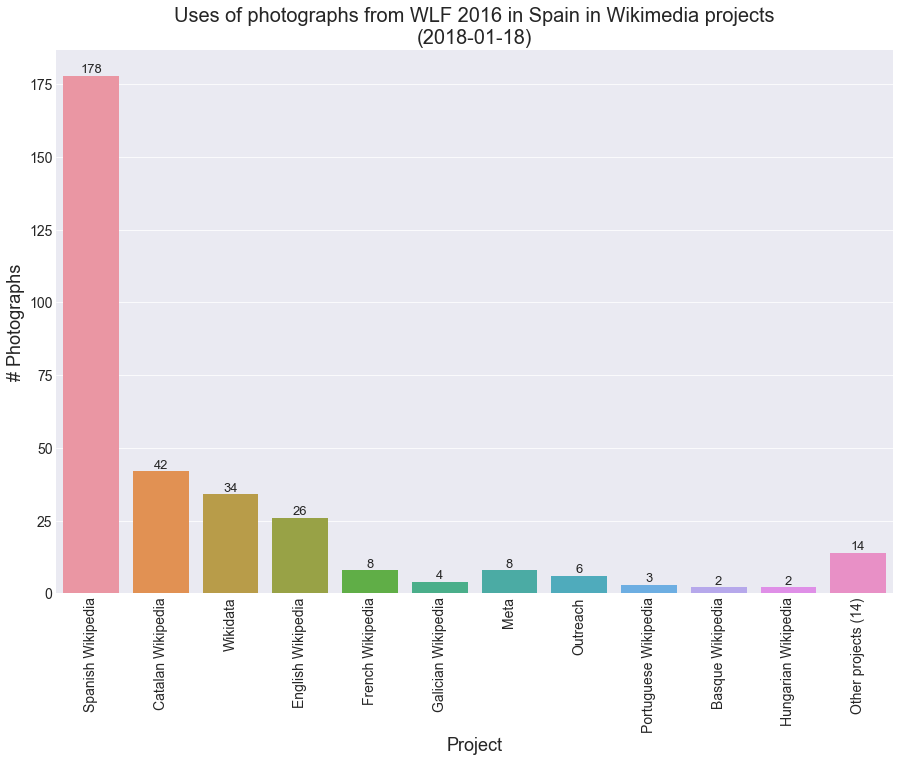

In [96]:
fig, ax = plt.subplots(figsize=figsize)

p = sns.barplot(ax=ax, x='index', y='usages', data=reduced_usages_df.reset_index())
p.set_xlabel("Project", fontsize=18)
p.set_ylabel("# Photographs", fontsize=18)

p.set_title(label='Uses of photographs from {2} {0} in Spain in Wikimedia projects\n({1})'.format(YEAR, now, TAG), fontsize=20)
p.tick_params(labelsize=14)

p.set_xticklabels(p.get_xticklabels(), rotation=90)

for patch in p.patches:
    height = patch.get_height()
    p.text(patch.get_x() + patch.get_width()/2.,
            height + 1,
            '{:1.0f}'.format(height),
            ha="center",
            fontsize=13)
    
upload_to_commons(p,
                  "{1} {0} in Spain - Uses of photographs in WMF projects.png".format(YEAR, TAG),
                  'Uses of photographs from {1} {0} in Spain in WMF projects: top 12 projects'.format(YEAR, TAG_EXT),
                  plot_description,
                  YEAR,
                  TAG_EXT
                 )

In [97]:
# Quality images gallery
template = """This page lists the ${len(QI_list)} '''[[Commons:Quality Images|quality images]]''' uploaded as part of the [[Commons:${tag}|${tag}]] contest in ${year} in Spain.

<gallery>
% for image in QI_list:
${image}
% endfor
</gallery>

'''Statistics generation date''': {{subst:CURRENTMONTHNAME}} {{subst:CURRENTDAY}}, {{subst:CURRENTYEAR}}

[[Category:${tag} in Spain| Quality]]

"""
vars = {
    "QI_list": qi_list.values,
    "tag": TAG_EXT,
    "year": YEAR
}
t = Template(template)
qi_gallery_text = t.render(**vars)

In [98]:
qi_page = pb.Page(commons_site, GALLERY_QI)
if qi_page.text != qi_gallery_text:
    qi_page.text = qi_gallery_text
    pb.output('Publishing --> {1} {0} in Spain featured articles gallery'.format(YEAR, TAG))
    qi_page.save("{1} {0} in Spain featured articles gallery".format(YEAR, TAG))

Publishing --> WLF 2016 in Spain featured articles gallery
Page [[Commons:Wiki Loves Folk/2016/QI]] saved


#### Finalists

In [99]:
cat_wlf = pb.Category(commons_site, WLF_FINALIST_CATEGORY)
gen_wlf = pagegenerators.CategorizedPageGenerator(cat_wlf)

finalist_images_wlf = [page.title(withNamespace=False) for page in gen_wlf if page.is_filepage()]
finalist_images_count = len(finalist_images_wlf)
finalist_images_count

116

In [100]:
finalist_images_df = images_extended_df[images_extended_df['image_title'].isin(finalist_images_wlf)]
finalist_authors = finalist_images_df['uploader'].value_counts()
finalist_authors = finalist_authors.iloc[np.lexsort([finalist_authors.index, -finalist_authors.values])]
finalist_authors

Rafesmar             27
SiegluXXI            26
Pedro J Pacheco      22
Discasto              7
Mikipons              7
Tamara k              5
ElBute                4
Ricardo Yagüe         4
Castellónenred        2
El Pantera            2
Maryna Dymovich       2
Montgomery            2
Antonio Sánchez       1
Dbascones             1
JulioC66              1
Nordentor             1
Rodelar               1
SantiagoPucelano1     1
Name: uploader, dtype: int64

In [101]:
finalist_authors_count = len(finalist_authors)
finalist_authors_count

18

[[commons:File:WLF 2016 in Spain - Finalists.png]]


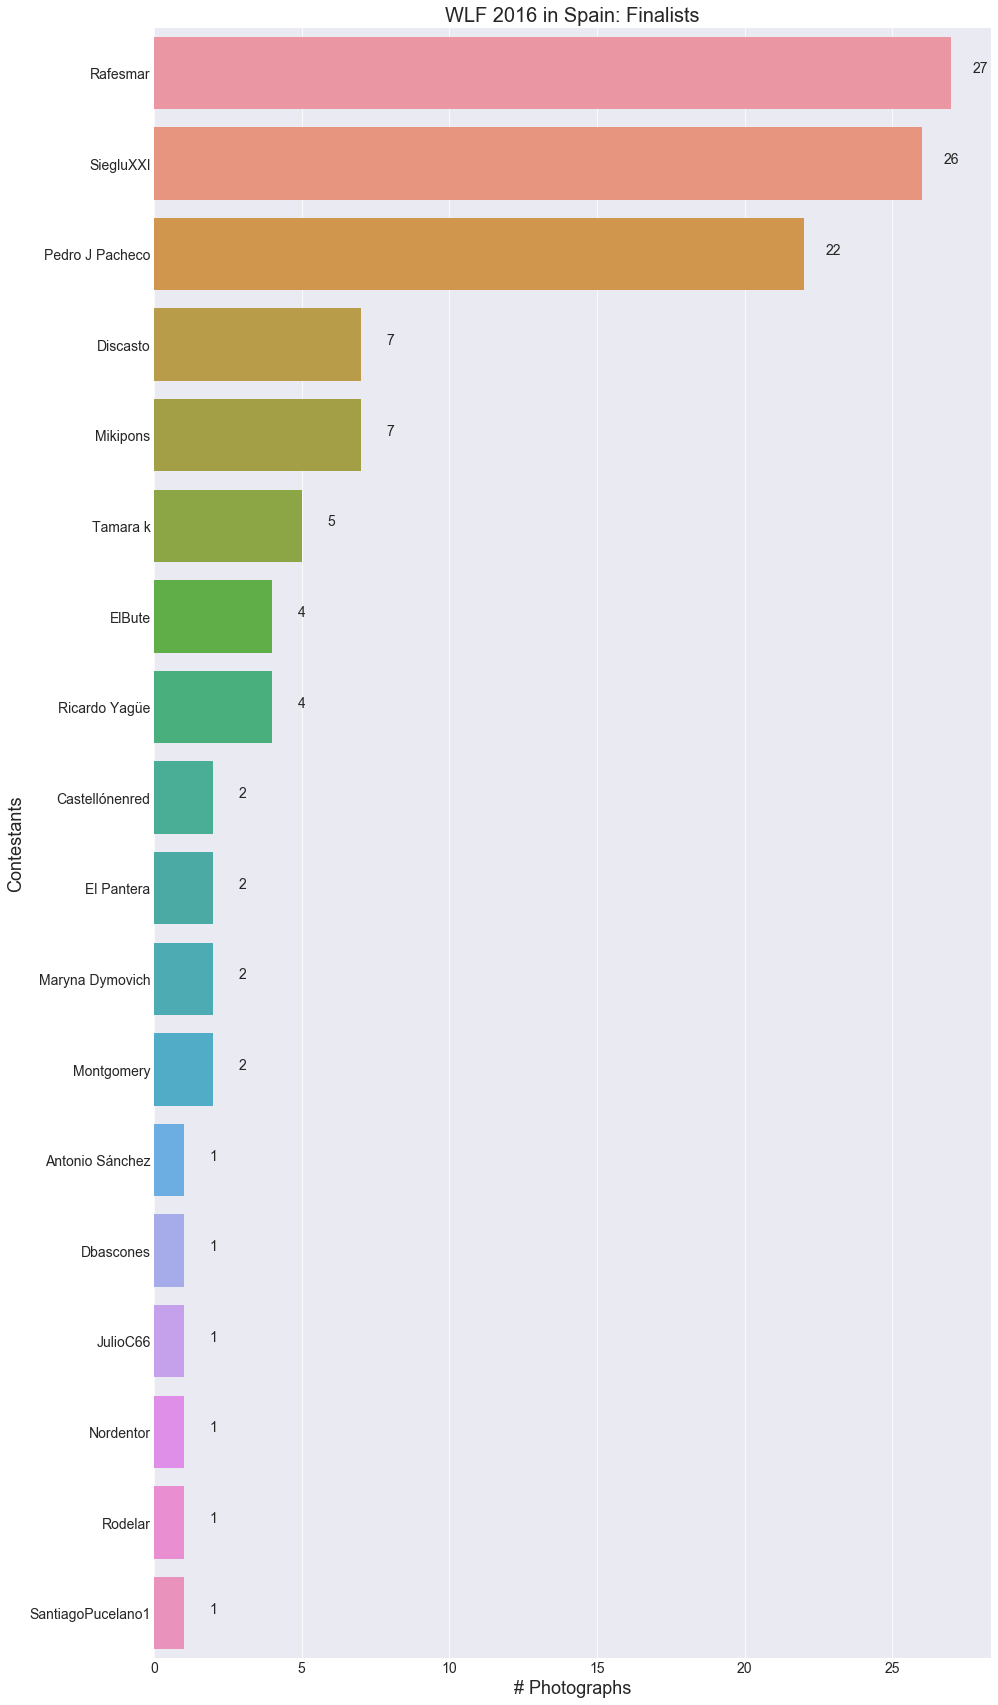

In [102]:
fig, ax = plt.subplots(figsize=figsize_high)

p = sns.barplot(ax=ax, y=finalist_authors.index.map(lambda x: wrap_label(x, 20)), x=finalist_authors.values)
p.set_xlabel("# Photographs", fontsize=18)
p.set_ylabel("Contestants", fontsize=18)

p.set_title(label='{1} {0} in Spain: Finalists'.format(YEAR, TAG), fontsize=20)
p.tick_params(labelsize=14)

for patch in ax.patches:
    ax.text(patch.get_width() + 1,
            patch.get_y() + patch.get_height()/2.,
            '{:1.0f}'.format(patch.get_width()),
            ha="center",
            fontsize=14)

upload_to_commons(p,
                  "{1} {0} in Spain - Finalists.png".format(YEAR, TAG),
                  'Top contributors reaching the final round of {1} {0} in Spain.'.format(YEAR, TAG_EXT),
                  plot_description,
                  YEAR,
                  TAG_EXT
                 )

In [103]:
finalist_festivals = finalist_images_df['category'].value_counts()
finalist_festivals = finalist_festivals.iloc[np.lexsort([finalist_festivals.index, -finalist_festivals.values])]
finalist_festivals

Falles de València                                                         31
Holy Week in Murcia                                                        21
Corpus Christi in Laguna de Negrillos                                       8
Festes de Sant Cristòfol de ses Corregudes, es Migjorn Gran                 6
Romería de Nuestra Señora de la Virgen del Villar, Carrizo de la Ribera     5
Shepherd's Festival, Los Barrios de Luna                                    5
Holy Week in Córdoba, Spain                                                 4
Fiesta del Asturcón                                                         3
Antruejo de Llamas de la Ribera                                             2
Antruejo de Velilla de la Reina                                             2
Carnivals of Las Palmas de Gran Canaria                                     2
Carnivals of Santa Cruz de Tenerife                                         2
Festa del Pi de Centelles                                       

[[commons:File:WLF 2016 in Spain - Finalist festivals.png]]


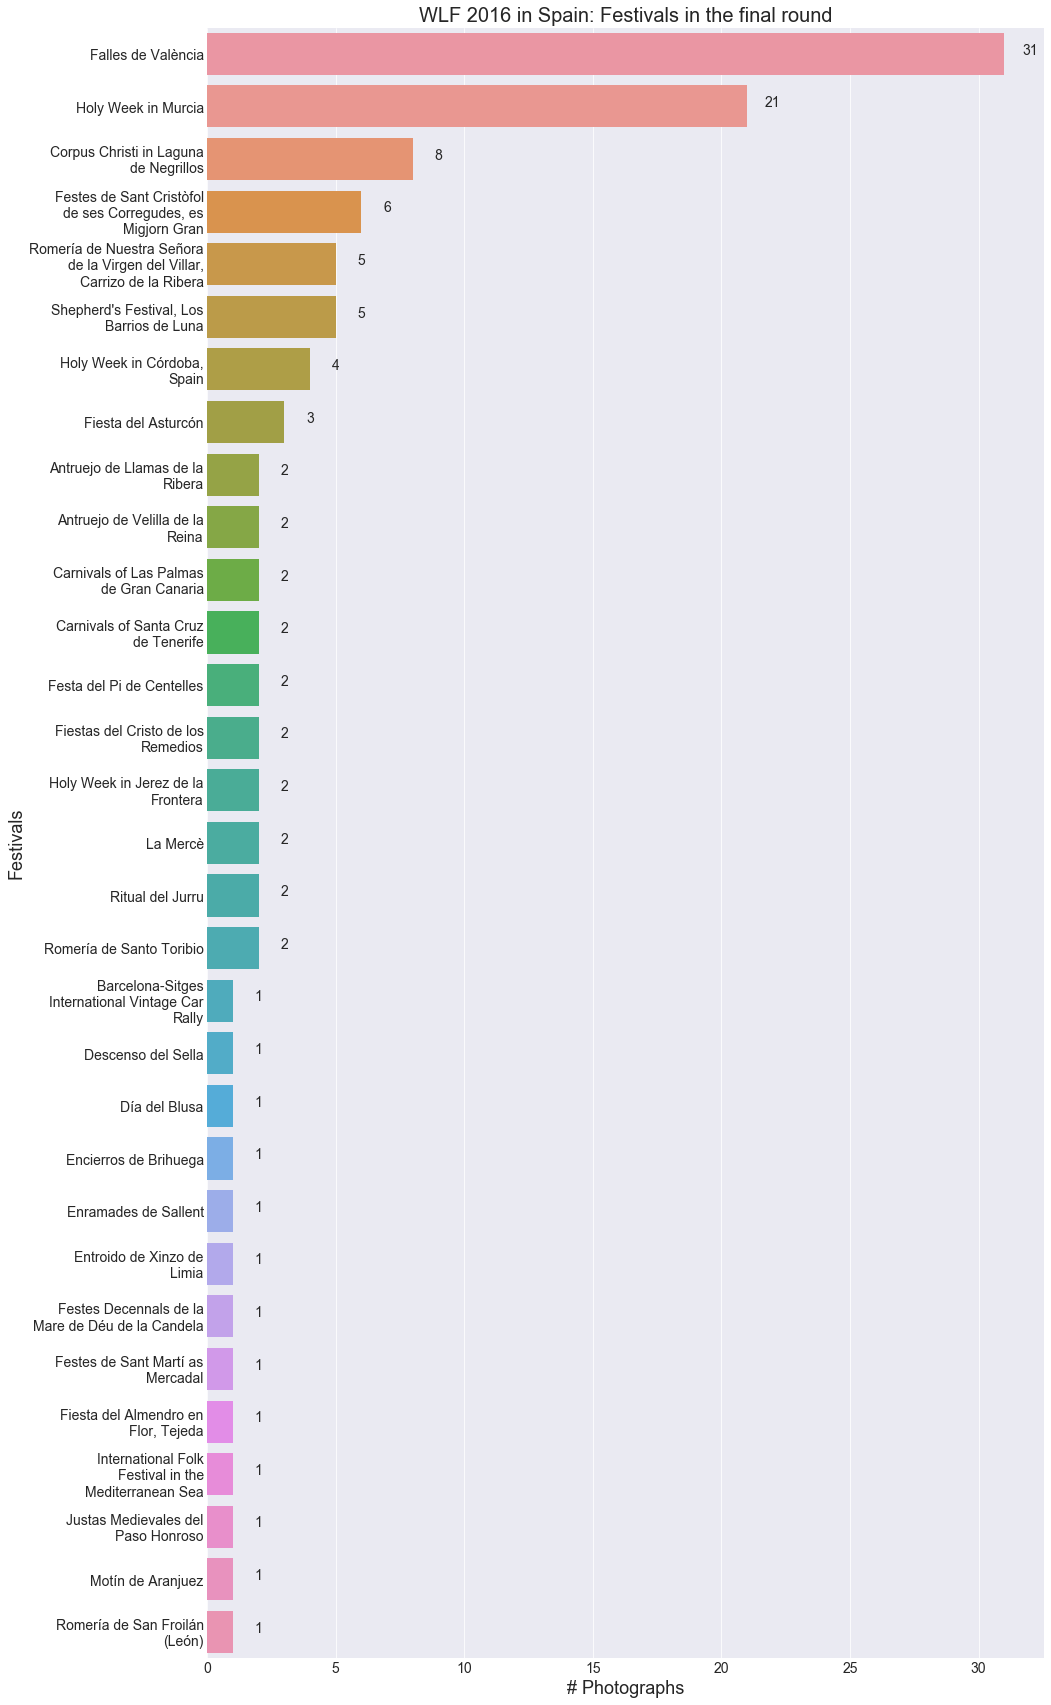

In [104]:
fig, ax = plt.subplots(figsize=figsize_high)

p = sns.barplot(ax=ax, y=finalist_festivals.index.map(lambda x: wrap_label(x, 25)), x=finalist_festivals.values)
p.set_xlabel("# Photographs", fontsize=18)
p.set_ylabel("Festivals", fontsize=18)

p.set_title(label='{1} {0} in Spain: Festivals in the final round'.format(YEAR, TAG), fontsize=20)
p.tick_params(labelsize=14)

for patch in ax.patches:
    ax.text(patch.get_width() + 1,
            patch.get_y() + patch.get_height()/2.,
            '{:1.0f}'.format(patch.get_width()),
            ha="center",
            fontsize=14)

upload_to_commons(p,
                  "{1} {0} in Spain - Finalist festivals.png".format(YEAR, TAG),
                  'Top festivals in the final round of {1} {0} in Spain.'.format(YEAR, TAG_EXT),
                  plot_description,
                  YEAR,
                  TAG_EXT
                 )

In [105]:
finalist_campaigns = finalist_images_df['campaign'].value_counts()
finalist_campaigns

autumn    55
spring    51
summer     6
           4
Name: campaign, dtype: int64

[[commons:File:WLF 2016 in Spain - Finalist campaigns.png]]


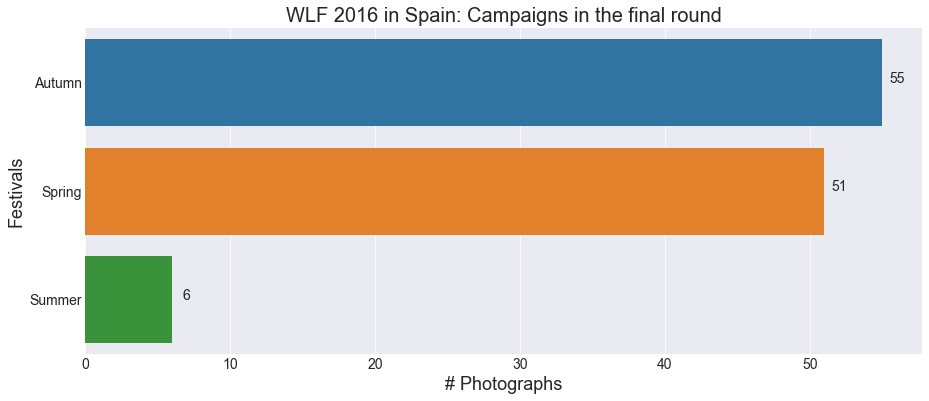

In [106]:
fig, ax = plt.subplots(figsize=figsize_low)

p = sns.barplot(ax=ax, y=finalist_campaigns[:3].index, x=finalist_campaigns[:3].values)
p.set_xlabel("# Photographs", fontsize=18)
p.set_ylabel("Festivals", fontsize=18)

p.set_title(label='{1} {0} in Spain: Campaigns in the final round'.format(YEAR, TAG), fontsize=20)
p.tick_params(labelsize=14)

for patch in ax.patches:
    ax.text(patch.get_width() + 1,
            patch.get_y() + patch.get_height()/2.,
            '{:1.0f}'.format(patch.get_width()),
            ha="center",
            fontsize=14)

p.set_yticklabels(['Autumn', 'Spring', 'Summer'])

upload_to_commons(p,
                  "{1} {0} in Spain - Finalist campaigns.png".format(YEAR, TAG),
                  'Campaigns in the final round of {1} {0} in Spain.'.format(YEAR, TAG_EXT),
                  plot_description,
                  YEAR,
                  TAG_EXT
                 )

In [107]:
finalist_autcoms = finalist_images_df['aut_com'].value_counts()
finalist_autcoms = finalist_autcoms.iloc[np.lexsort([finalist_autcoms.index, -finalist_autcoms.values])]
finalist_autcoms

Valencian Community    31
Castile and León       28
Region of Murcia       22
Balearic Islands        7
Catalonia               7
Andalusia               6
Canary Islands          5
Asturias                4
Community of Madrid     3
Basque Country          1
Castile-La Mancha       1
Galicia                 1
Name: aut_com, dtype: int64

[[commons:File:WLF 2016 in Spain - Finalist autonomous communities.png]]


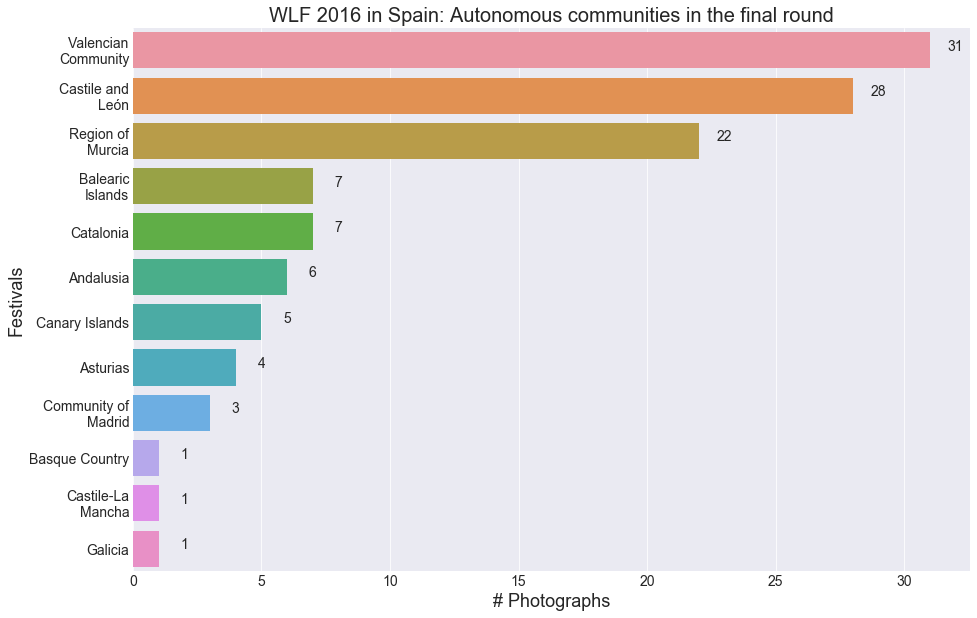

In [108]:
fig, ax = plt.subplots(figsize=figsize)

p = sns.barplot(ax=ax, y=finalist_autcoms.index.map(lambda x: wrap_label(x, 14)), x=finalist_autcoms.values)
p.set_xlabel("# Photographs", fontsize=18)
p.set_ylabel("Festivals", fontsize=18)

p.set_title(label='{1} {0} in Spain: Autonomous communities in the final round'.format(YEAR, TAG), fontsize=20)
p.tick_params(labelsize=14)

for patch in ax.patches:
    ax.text(patch.get_width() + 1,
            patch.get_y() + patch.get_height()/2.,
            '{:1.0f}'.format(patch.get_width()),
            ha="center",
            fontsize=14)

upload_to_commons(p,
                  "{1} {0} in Spain - Finalist autonomous communities.png".format(YEAR, TAG),
                  'Spanish autonomous communities in the final round of {1} {0} in Spain.'.format(YEAR, TAG_EXT),
                  plot_description,
                  YEAR,
                  TAG_EXT
                 )

In [109]:
template_file = os.path.join(templates_directory, 'wlf{0}.wiki'.format(YEAR))
fh = open(template_file, 'r', encoding = "utf-8")
template = fh.read()
fh.close()

In [110]:
vars = {
    "images_length": total_images_length,
    "valid_images_length": valid_images_length,
    "festival_images_length": 0,
    "qi_length": qi_length,
    "gallery_quality_images": GALLERY_QI,
    "wlf_festivals_length": wlf_festivals_length,
    "authors_length": authors_length,
    "new_uploaders_length": new_uploaders_length,
    "festival_length": festival_length,
    "aut_coms": aut_coms,
    "authors_df": authors_df,
    "images_per_festival_df": images_per_festival_df,
    "usages_df": usages_df,
    "total_unique": total_unique,
    "new_uploaders": new_uploaders,
    "new_uploaders_sum": new_uploaders.sum(),
    "campaign_count": campaign_count,
    "finalist_images_count": finalist_images_count,
    "finalist_authors_count": finalist_authors_count,
    "annexes": {i[1]: i[0] for i in festival_annexes},
    "map": dump,
    "year": YEAR,
    "tag": TAG,
    "full_tag": TAG_EXT,
    "base": BASE_WLF_NAME
}
t = Template(template)
statisticts_text = t.render(**vars)

In [111]:
stats_page = pb.Page(commons_site, STATISTICS_PAGE)
stats_page.text = statisticts_text
pb.output('Publishing --> {1} {0} in Spain Statistics'.format(YEAR, TAG))
stats_page.save("{1} {0} in Spain statistics".format(YEAR, TAG))

Publishing --> WLF 2016 in Spain Statistics
Sleeping for 7.1 seconds, 2018-01-18 22:53:34
Page [[Commons:Wiki Loves Folk/2016/Stats]] saved
